# The latest version of the code that calculates the effect of atmospheric scatter on FPI measurements.

from: http://remote2.ece.illinois.edu/~bhardin2/tmp/
It includes:
- Multiple scattering
- User-specified scattering phase function
- Horizontal winds and temperature estimated from FPI data
- Stray light model for FPI measurement based on lab measurements of UAO
- BU imager data
- Corrections to BU imager data to handle stray light, atmospheric scatter, and atmospheric extinction

Some prototypes of improvements are in other notebooks:
- 2D source brightness
- ASI calibrations, used for starting with raw data

These other improvements are not necessary for using the BU data during storms, but may be important for other uses (e.g., explaining the dusk vertical winds in Brazil).

In [1]:
%pylab inline

# Change matplotlib defaults
matplotlib.rcParams['savefig.dpi'] = 150
matplotlib.rcParams['figure.figsize'] = (4,3)
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['ytick.labelsize'] = 'small'
matplotlib.rcParams['xtick.labelsize'] = 'small'
matplotlib.rcParams['legend.fancybox'] = 'True'
matplotlib.rcParams['legend.fontsize'] = 'small'
matplotlib.rcParams['legend.numpoints'] = 1

from matplotlib.colors import LogNorm
from scipy import interpolate
from datetime import datetime, timedelta

import sys
import time as time_mod
from IPython.display import display, clear_output

import scipy.sparse as sp
from scipy.sparse import linalg as splinalg

import FPIprocess
from matplotlib import dates
import pytz
import FPI
import glob
from scipy.io import readsav # read IDL save files

sec = lambda(x): 1/cos(x)

import atmospheric_scatter
reload(atmospheric_scatter)
from atmospheric_scatter import *


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load AERONET data to determine aerosol optical depth

In [2]:
def cast_float(s):
    if s == 'N/A':
        return np.nan
    else:
        return float(s)

In [3]:
#aeronet_fn = '/home/bhardin2/AERONET/131001_131031_Billerica.lev20'
aeronet_fn = '/home/bhardin2/AERONET/131001_131031_Harvard_Forest.lev20'
tstart = datetime(2013,10,1, 0,0,0)
tstop  = datetime(2013,10,3, 0,0,0)


f = open(aeronet_fn,'r')
T = []
t = []
# Read headers
for i in range(5):
    s = f.readline()
    v = s.split(',')
# Read wavelength coordinates
lam = [cast_float(v[i].split('_')[-1]) for i in range(3,19)]
# Load the data
for s in f:
    #s = f.readline()
    v = s.split(',')
    ti = datetime.strptime(' '.join((v[0],v[1])),'%d:%m:%Y %H:%M:%S')
    if (ti >= tstart) and (ti <= tstop):
        t.append(ti)
        T.append([cast_float(v[i]) for i in range(3,19)])
    
T = array(T)
lam = array(lam)
t = array(t)
f.close()



In [4]:
# Interpolate to the red line wavelength
aeronet_tau_630 = zeros(len(t))
for j in range(len(t)):

    Tj = T[j,:]
    idx = ~isnan(Tj)
    lamj = lam[idx]
    Tj = Tj[idx]
    aeronet_tau_630[j] = interpolate.interp1d(lamj, Tj)(630)

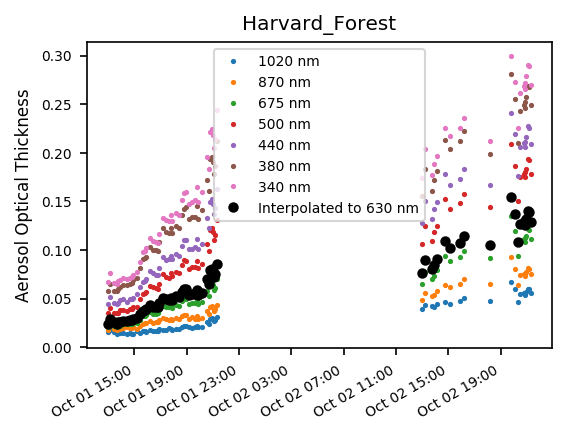

In [5]:
for i in range(len(lam)):
    if any(~isnan(T[:,i])):
        plot(t, T[:,i],'.',label='%.0f nm' % lam[i], markersize=3)
plot(t,aeronet_tau_630, 'k.', markersize=8, label='Interpolated to 630 nm')
legend(loc='best')
ylabel('Aerosol Optical Thickness')
gca().xaxis.set_major_formatter(dates.DateFormatter('%b %d %H:00'))
gcf().autofmt_xdate()
title(aeronet_fn.split('/')[-1][14:-6])

#savefig('/home/bhardin2/public_html/atmospheric_scatter/aerosol_data.png')


In [6]:
#for i in range(len(t)):
#    print i,t[i]

In [7]:
mean2 =  mean(aeronet_tau_630[t > datetime(2013,10,2,10,0,0)])
mean1 =  mean(aeronet_tau_630[t < datetime(2013,10,2,10,0,0)])
intp1 =  mean(aeronet_tau_630[44:46])
print 'Mean tau day before: %.3f' % mean1
print 'Mean tau day after:  %.3f' % mean2
print 'Avg tau across gap:  %.3f' % intp1

Mean tau day before: 0.048
Mean tau day after:  0.115
Avg tau across gap:  0.081


## Global atmospheric and simulation parameters

In [54]:
RE = 6371e3
h = 220e3 # Assumed altitude of emission in model
hcal = 400e3 # Altitude that Carlos assumed to do ASI calibrations
M = 10 # RT: resolution in altitude
N = 10  # RT: resolution in zenith angle (ideally, even but not a multiple of 4)
R = 10  # RT: resolution in azimuth angle
N_int = 20 # RT: source brightness resolution
R_int = 20 # RT: source brightness resolution
Q_int = 30 # resolution of FPI stray light calculation
L = 20 # number of wavelength bins

om_aerosol = 1.0 # single-scattering albedo
tau0_aerosol = 0.067

tau0_rayleigh = 0.0558 # Bodhaine et al 1999.


############################## SCATTERING PHASE FUNCTION #####################################

##### FROM AERONET #####
# Billerico site; Oct 02 2013; green triangles
xy_data = array([
    0.00000, 54.44463,
    1.46520, 35.06622,
    3.84615, 18.12520,
    6.04396, 12.13510,
    8.60806, 9.86415,
    30.40293, 3.78018,
    39.92674, 2.46469,
    50.91575, 1.27302,
    64.10256, 0.65739,
    72.89377, 0.43423,
    83.33333, 0.27946,
    94.13919, 0.19436,
    103.66300, 0.14993,
    117.03297, 0.12176,
    124.90842, 0.11259,
    137.54579, 0.11393,
    147.43590, 0.12625,
    157.87546, 0.14923,
    170.32967, 0.16533,
    175.09158, 0.17403,
    180.0, 0.17852,   
    ])
gamma_data_deg = xy_data[0::2]
P_data = xy_data[1::2]

##### FROM ABREU ET AL [1983] #####
#gamma_data_deg = array([0., 5., 30., 45., 60., 75., 90., 105., 120., 135., 150., 165., 180.])
#P_data = array([4.6, 3.3, 1.9, 1.3, 0.94, 0.75, 0.64, 0.65, 0.72, 0.85, 1.03, 1.1, 1.2])

##### ISOTROPIC #####
#gamma_data_deg = linspace(0,180,5)
#P_data = ones(len(gamma_data_deg))

# Careful with how you interpret independent variable. Always ensure that P integrates to 4pi
u_data = cos(gamma_data_deg*pi/180.) 
P_aerosol_interp = interpolate.interp1d(u_data, P_data)

def P_aerosol(u0,u1,phi0,phi1):
    '''
    Scattering phase function, defined so it integrates to 4*pi over the sphere.
    '''
    u = u0*u1 + sqrt((1-u0**2)*(1-u1**2)) * cos(phi0-phi1) # cos (scattering angle)
    try:
        Pinterp = P_aerosol_interp(u)
    except ValueError as e:
        print u
        raise
    return Pinterp
    #return 1
    
def P_rayleigh(u0,u1,phi0,phi1):
    '''
    Scattering phase function, defined so it integrates to 4*pi over the sphere.
    '''
    u = u0*u1 + sqrt((1-u0**2)*(1-u1**2)) * cos(phi0-phi1) # cos (scattering angle)
    return 0.75 * (1 + u**2)


# Calculate total radiative properties
tau0 = tau0_aerosol + tau0_rayleigh
P = lambda u0,u1,phi0,phi1: tau0_aerosol/tau0*P_aerosol(u0,u1,phi0,phi1) + tau0_rayleigh/tau0*P_rayleigh(u0,u1,phi0,phi1)
om = tau0_aerosol/tau0 * om_aerosol + tau0_rayleigh/tau0 * 1 # weighted average

In [55]:
NP = 100
dIr = zeros((NP,NP))
dIa = zeros((NP,NP))
u_w = linspace(-1,1,NP+1)
u = (u_w[1:] + u_w[:-1])/2
phi_w = linspace(0,2*pi,NP+1)
phi = (phi_w[1:] + phi_w[:-1])/2
du = u[1]-u[0]
dphi = phi[1]-phi[0]
for i in range(NP):
    for j in range(NP):
        dIr[i,j] = P_rayleigh(u[i],0,phi[j],0)
        dIa[i,j] = P_aerosol(u[i],0,phi[j],0)
        
        
Ir = sum(dIr*du*dphi)
print 'P_rayleigh integrates to %.2f*pi' % (Ir/pi)
Ia = sum(dIa*du*dphi)
print 'P_aerosol integrates to %.2f*pi' % (Ia/pi)



P_rayleigh integrates to 4.00*pi
P_aerosol integrates to 4.18*pi


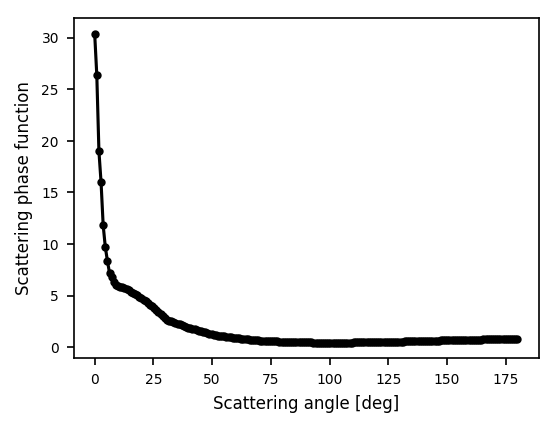

In [56]:
gamma = linspace(0,180,200)
plot(gamma, P(1,cos(gamma*pi/180),0,0), 'k.-')
xlabel('Scattering angle [deg]')
ylabel('Scattering phase function')

### Instrument stray light

In [57]:
full_fov_deg = 1.8 # field of view, full, according to http://75.146.7.178:5000/redlinedescribe.html

############## Measured lab data from UAO instrument. Assume same for all FPIs #################
# This was taken with the dome on and front glass on
lab_data = \
[(5, 0.005129426700690165),
 (10, 0.0012465447519429053),
 (15, 0.00047971740939220514),
 (20, 0.00022854395277848729),
 (30, 6.9782733496369617e-05),
 (40, 2.9184675263585164e-05),
 (50, 1.5186020692288823e-05),
 (60, 9.5178964778598577e-06),
 (70, 6.8871028519547916e-06),
 (80, 4.1026723956976625e-06),
 #(90, 1.5616583167472997e-07),
 #(100, 1.1367860945391276e-06), # ignore data past 90 deg
 #(110, 1.6052835895633173e-06)
]

angle = array([x[0] for x in lab_data])
scatt = array([x[1] for x in lab_data])
idx = scatt > 0.0

y = log10(scatt[idx])
x = angle[idx]
coeff_scatt = polyfit(x, y, 5)

def q(angle_between):
    '''
    Stray energy fraction as defined in notes on 2016-03-26.
    
    angle_between: rad, the angle between the look direction and the 
                   source being considered. This is 0 if the instrument
                   is looking at the source.
    '''
    
    # Plug this angle into polynomial fit to determine scattering ratio
    scatt_ratio = 10**polyval(coeff_scatt, angle_between*180/pi)
    
    # Determine stray light fraction
    qi = scatt_ratio/cos(angle_between) # See notes 2016-03-28 for why this is the right thing

    # Use zero-order extrapolation for non-measured angles
    if angle_between < angle[0]*pi/180:
        qi = 10**polyval(coeff_scatt, angle[0]) / cos(angle[0]*pi/180)
    if angle_between > angle[-1]*pi/180:
        qi = 10**polyval(coeff_scatt, angle[-1]) / cos(angle[-1]*pi/180)

    # See notes 2016-03-28 for why this is the right thing
    return qi


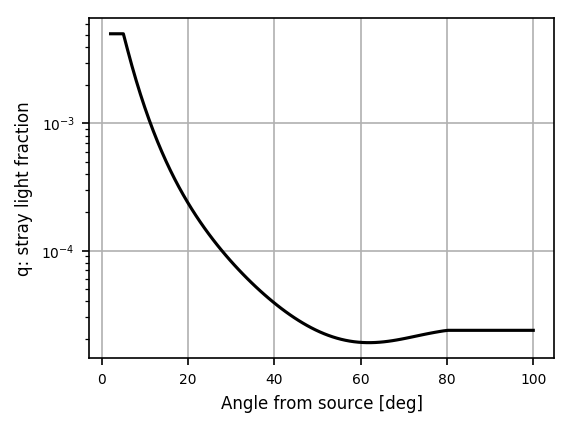

In [58]:
angle_fit = linspace(2,100,100)
q_fit = array([q(angle_fit[i]*pi/180) for i in range(len(angle_fit))])
semilogy(angle_fit, q_fit, 'k-')
grid()
xlabel('Angle from source [deg]')
ylabel('q: stray light fraction')
#savefig('/home/bhardin2/public_html/tmp/scatter_ratio.pdf')

# Use BU imager to determine airglow source

In [59]:
def spatial_cal(h=400e3):
    
    # First, undo the spatial cal that Carlos did at 400 km. Then re-do it for the desired altitude.
    
    ############ Spatial calibration ################
    from scipy.io import readsav # read IDL save files
    lats = array([ 50,  50,  50,  50,  45,  45,  45,  40,  40,  40,  35,  35 ])
    lons = array([-80, -75, -70, -65, -85, -75, -65, -85, -75, -65, -80, -70])

    xydata = array([
    294.77561, 538.50975,
    356.88537, 534.82643,
    420.19373, 533.52608,
    482.31570, 536.99776,
    215.78770, 451.59150,
    353.13693, 438.23997,
    490.51058, 439.19845,
    201.28844, 355.02336,
    349.38645, 340.46101,
    496.31842, 342.59571,
    265.61022, 247.58840,
    424.47534, 242.54774,
    ])

    x = xydata[::2]
    y = xydata[1::2]

    import fpiinfo
    site = fpiinfo.get_site_info('mh')
    sitelat = site['Location'][0]
    sitelon = site['Location'][1]

    n = len(x)
    A = zeros((n,6))
    A[:,0] = 1.
    A[:,1] = x
    A[:,2] = y
    A[:,3] = x*y
    A[:,4] = x**2
    A[:,5] = y**2

    res_lat = linalg.lstsq(A,lats)
    c_lat = res_lat[0]

    res_lon = linalg.lstsq(A,lons)
    c_lon = res_lon[0]
    
    # Load coordinates
    Xi,Yi = meshgrid(arange(100,700),arange(100,700))
    LAT = c_lat[0] + c_lat[1]*Xi + c_lat[2]*Yi + c_lat[3]*Xi*Yi + c_lat[4]*Xi**2 + c_lat[5]*Yi**2
    LON = c_lon[0] + c_lon[1]*Xi + c_lon[2]*Yi + c_lon[3]*Xi*Yi + c_lon[4]*Xi**2 + c_lon[5]*Yi**2
    # Convert to x,y
    DLAT = LAT - sitelat
    DLON = LON - sitelon
    X = DLON*111e3*cos(LAT*pi/180)
    Y = DLAT*111e3
    
    # Determine az and ze for projecting up to a different height
    rho = sqrt(X**2 + Y**2)
    th = arcsin((RE+hcal)/sqrt(RE**2 + (RE+hcal)**2 - 2*RE*(RE+hcal)*cos(rho/(RE+hcal))) * sin(rho/(RE+hcal)))
    az = arctan2(Y,X) # math convention
    GAMMAcal = arcsin(RE/(RE+hcal) * sin(th)) # zenith angle (slant angle) at pierce point  
    
    # Project up to a different height, h
    GAMMA = arcsin(RE/(RE+h) * sin(th)) # zenith angle (slant angle) at pierce point
    rhonew = (RE+h)*(th-GAMMA)
    Xnew = rhonew*cos(az)
    Ynew = rhonew*sin(az)
    
    return Xnew,Ynew,sitelat,sitelon,GAMMA,GAMMAcal

X,Y,sitelat,sitelon,GAMMA,GAMMAcal = spatial_cal(h)

from scipy.io import readsav # read IDL save files

In [60]:
########### Load a particular file ###############

#bu_fn = '/home/bhardin2/BU_ASI_data/M073345.sav'
#bu_fn = '/home/bhardin2/BU_ASI_data/M060640.sav'
#bu_fn = '/home/bhardin2/BU_ASI_data/M033236.sav'
bu_fn = '/home/bhardin2/BU_ASI_data/M045259.sav'

# Where to sample to determine stray light
stray_factor = 1.0
iv = [100, 50,  500, 500]
jv = [400,300, 110, 500]

bu_file = readsav(bu_fn)
im = bu_file['theimage'][100:700,100:700]

# ASI stray light correction
# Un-correct for van Rhijn
im = im*sec(GAMMAcal)
# Subtract background/stray-light/whatever-it-is
bgs = []
for kk in range(len(iv)):
    bgs.append(im[iv[kk],jv[kk]])
bg = stray_factor*mean(bgs)
#bg = 0.08 * prctile(im,95)
im = im - bg
# Re-correct for van Rhijn at new altitude
im = im/sec(GAMMA)

# Load time
t_asi_str = bu_fn.split('/')[-1][1:7]
asi_t = datetime(2013,10,2, int(t_asi_str[0:2]), int(t_asi_str[2:4]), int(t_asi_str[4:6]))


width = 10 # pixels

# Find center of image
idx = argmin(X**2 + Y**2)
ic,jc = unravel_index(idx, shape(im))

# Create a cut averaged over a strip around y=0
imcut_raw = mean(im[:,jc-10:jc+10],axis=1)
yim_raw = Y[:,jc]

# Manually define a mask based on the trees.
yim = yim_raw[159:466]
imcut = imcut_raw[159:466]

# Define 2D brightness distribution function
dhf_interp = interpolate.interp1d(yim, imcut, bounds_error = False)

def dhf(x,y):
    '''
    Airglow source VER function, integrated vertically. (i.e., thin-shell approximation).
    It is assumed that input variables are arrays of the same size.
    '''
    r_max = (RE+h) * arccos(RE/(RE+h))
    f = dhf_interp(y)
    f[y < yim[0]] = imcut[0] # Zero-order-hold extrapolation
    f[y > yim[-1]] = imcut[-1] # Zero-order-hold extrapolation
    f[x**2 + y**2 > r_max**2] = 0.0 # Nothing beyond horizon
    return f

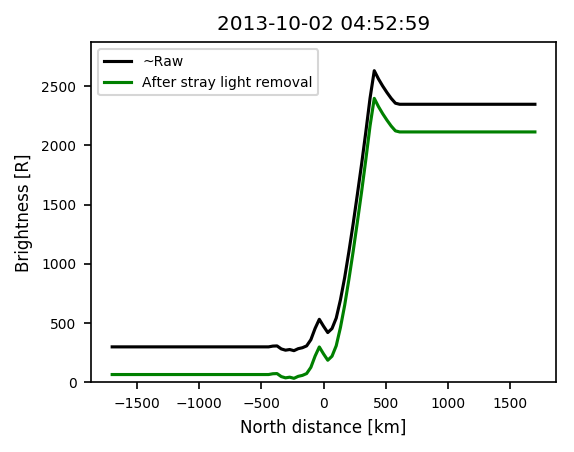

In [62]:
yvec = linspace(-1700e3,1700e3,101)
Bvec = dhf(zeros(len(yvec)), yvec)
plot(yvec/1e3, Bvec + bg, 'k-', label='~Raw')
plot(yvec/1e3, Bvec,'g-', label='After stray light removal')

xlabel('North distance [km]')
ylabel('Brightness [R]')
ylim((0,1.1*max(Bvec) + bg))
title(asi_t)
legend(loc='best')

In [63]:
import atmospheric_scatter
reload(atmospheric_scatter)
from atmospheric_scatter import *

In [64]:
dhf_descatter = descatter_asi_data(imcut, yim, tau0, P, h, om=om, M=M, N=N, R=R, N_int=N_int, R_int=R_int, verbose = True)

5/5


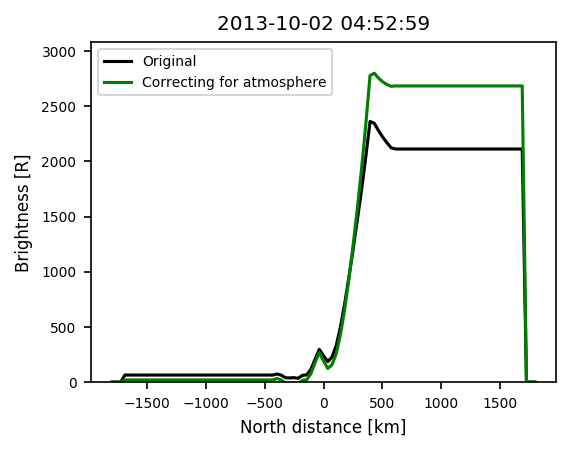

In [65]:
yvec = linspace(-1800e3,1800e3,101)
Bvec = dhf(zeros(len(yvec)), yvec)
Bvec_descatter = dhf_descatter(zeros(len(yvec)), yvec)
plot(yvec/1e3, Bvec,'k-',label='Original')
plot(yvec/1e3, Bvec_descatter,'g-', label='Correcting for atmosphere')
xlabel('North distance [km]')
ylabel('Brightness [R]')
ylim((0,1.1*max(Bvec_descatter)))
legend(loc='best')
title(asi_t)

#savefig('/home/bhardin2/public_html/atmospheric_scatter/ASI_descatter.png')

In [66]:
dhf = dhf_descatter

# Extend to function of wavelength

This should be as simple as plugging in a different airglow source, which depends on wavelength

# Load FPI data

In [67]:
fpir = FPIprocess.load_level0('noto01', 2013, 274)['FPI_Results']
#fpir = FPIprocess.load_level0('minime08',2013,274)['FPI_Results']

# Re-establish Doppler ref (why doesn't this work well?)
#dref, dreferr = FPI.DopplerReference(fpir, reference='laser', statistic='median')
#fpir['LOSwind'] = fpir['LOSwind'] - dref

direction = fpir['direction']
fpi_los_wind = {}
fpi_temp = {}
fpi_intensity = {}
fpi_t = {}
for direc in list(set(direction)):
    fpi_los_wind[direc] = array([w for (w,d) in zip(fpir['LOSwind'], fpir['direction']) if d==direc])
    fpi_temp[direc]     = array([w for (w,d) in zip(fpir['T'], fpir['direction']) if d==direc])
    fpi_intensity[direc]= array([w for (w,d) in zip(fpir['skyI'], fpir['direction']) if d==direc])
    fpi_t[direc]        = array([w.astimezone(pytz.utc).replace(tzinfo=None)\
                                 for (w,d) in zip(fpir['sky_times'], fpir['direction']) if d==direc])

# Re-establish Doppler ref
dref = mean(fpi_los_wind['Zenith'][0:9])
for direc in fpi_los_wind.keys():
    fpi_los_wind[direc] -= dref

# Transform to cardinal winds
fpi_wind = {}
for direc in fpi_los_wind.keys():
    if direc == 'Zenith':
        fpi_wind[direc] = fpi_los_wind[direc]
    else:
        fpi_wind[direc] = fpi_los_wind[direc]/cos(pi/4)
fpi_wind['West'] = -fpi_wind['West']
fpi_wind['South'] = -fpi_wind['South']

In [68]:
# Find the FPI sample nearest in time to estimate the horz wind and temperature
fpi_idx = {}
for direc in fpi_t.keys():
     fpi_idx[direc] = argmin(abs(array([(t-asi_t).total_seconds() for t in fpi_t[direc]])))

T_fpi = fpi_temp['North'][fpi_idx['North']]
v_fpi = fpi_wind['North'][fpi_idx['North']]

# How to find zonal wind? Just pick one of these:
u_east = fpi_wind['East'][fpi_idx['East']]
u_west = fpi_wind['West'][fpi_idx['West']]
u_los = (fpi_los_wind['East'][fpi_idx['East']]-fpi_los_wind['West'][fpi_idx['West']])/cos(pi/4)
u_fpi = u_los

# Apparent vertical wind
w_app_fpi = fpi_wind['Zenith'][fpi_idx['Zenith']]


print 'T_fpi = %.1f K' % T_fpi
print 'u_fpi = %.1f m/s' % u_fpi
print 'v_fpi = %.1f m/s' % v_fpi
print 'w_app_fpi = %.1f m/s' % w_app_fpi


T_fpi = 1170.6 K
u_fpi = -67.7 m/s
v_fpi = -397.6 m/s
w_app_fpi = -91.1 m/s


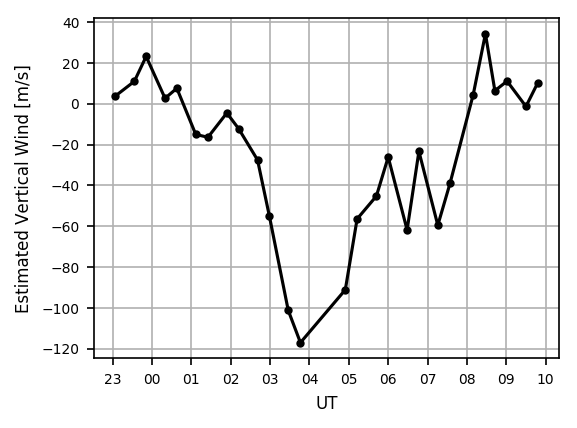

In [69]:
plot(fpi_t['Zenith'], fpi_wind['Zenith'],'k.-')
gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
grid()
xlabel('UT')
ylabel('Estimated Vertical Wind [m/s]')

# Simulate measured spectra

In [70]:
reload(atmospheric_scatter)
from atmospheric_scatter import *

In [71]:
q_to_use = q # Specify whether to model FPI stray light

th_look  = array([0.0])
phi_look = array([0.0])
name_look = ['Zenith']

#th_look  = array([45.0])
#phi_look = array([180.0])
#name_look = ['South']

Nlook = len(th_look)

T = T_fpi
uwind = u_fpi
vwind = v_fpi
wwind = 0.0

uvw = array([uwind, vwind, wwind])


v, spectrum_scatt, spectrum_direct, spectrum_scatt_stray, spectrum_direct_stray = scattered_and_direct_spectra(dhf, 
                                             tau0, P, h, th_look, phi_look, uvw, T, om=om,
                                             q=q_to_use, full_fov_deg=full_fov_deg, M=M, N=N, R=R, N_int=N_int,
                                             R_int=R_int, Q_int=Q_int, L=L, verbose=True)

spectrum_meas = spectrum_direct + spectrum_scatt + spectrum_scatt_stray + spectrum_direct_stray

20/20


App. LoS wind    = -90.36 m/s     Error = -90.4 m/s
App. temperature = 1211.73 K       Error = 41.1 K


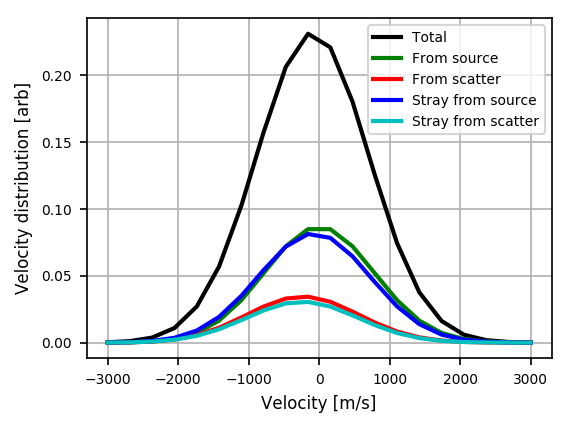

In [72]:
lw = 2

plot(v,spectrum_meas[0,:],       'k-', label='Total', linewidth=lw)
plot(v,spectrum_direct[0,:], 'g-', label='From source', linewidth=lw)
plot(v,spectrum_scatt[0,:], 'r-', label='From scatter', linewidth=lw)
plot(v,spectrum_direct_stray[0,:], 'b-', label='Stray from source', linewidth=lw)
plot(v,spectrum_scatt_stray[0,:], 'c-', label='Stray from scatter', linewidth=lw)
title('')
xlabel('Velocity [m/s]')
ylabel('Velocity distribution [arb]')
legend(loc='best')
grid()
#savefig('/home/bhardin2/public_html/tmp/spectra.pdf')

# Analyze spectrum and print results
look_direct = [0,0,1]
los_wind_direct = dot(look_direct, uvw)
w_app, T_app, I_app = analyze_spectrum(v,spectrum_meas[0,:])
w_err = w_app - los_wind_direct
T_err = T_app - T
print 'App. LoS wind    = %.2f m/s     Error = %.1f m/s' % (w_app, w_err)
print 'App. temperature = %.2f K       Error = %.1f K'   % (T_app, T_err)

# Loop over time: Vertical wind

In [73]:
q_to_use = q

th_look  = array([0.0])
phi_look = array([0.0])
name_look = ['Zenith']
Nlook = len(th_look)

# Where to sample to determine stray light
stray_factor = 1.0 # 0 = don't remove stray light, 1 = remove all stray light
iv = [100, 50,  500, 500]
jv = [400,300, 110, 500]
# Updated 2016 Dec 7 so that the brightness in the South doesn't go negative
iv = [140, 50,  180, 250]
jv = [440,300, 100, 500]

instr_name = 'noto01'
year = 2013
doy = 274

bu_fns = glob.glob('/home/bhardin2/BU_ASI_data/*.sav')
bu_fns.sort()
#bu_fns = [bu_fns[10], bu_fns[32],bu_fns[42],bu_fns[50]]
bu_fns = bu_fns[1::5]

t_vec = []
w_app_mine = zeros(len(bu_fns))
asi_orig_vec = []
asi_bg_vec = [] # brightness removed for stray light
asi_scatt_vec = [] # brightness removed for atmospheric scatter
I_south_vec = [] # actual vertical brightness at South pierce point (to check negativity)
I_north_vec = [] # actual vertical brightness at North pierce point
I_zenith_vec = [] # actual vertical brightness at Zenith pierce point 
model_intensity = {}
for direc in ['North','South','Zenith']:
    model_intensity[direc] = []
# Save estimated sky brightness map
Xs,Ys = meshgrid(linspace(-1000e3,1000e3,100),linspace(-1000e3,1000e3,100))
dhf_save = zeros((shape(Xs)[0], shape(Xs)[1], len(bu_fns)))

for ii in range(len(bu_fns)):
    
    clear_output(wait=True)
    time_mod.sleep(0.01)
    print '%i/%i '%(ii+1,len(bu_fns))
    sys.stdout.flush()
    
    ######################################### LOAD ASI DATA ####################################################
    bu_fn = bu_fns[ii]

    bu_file = readsav(bu_fn)
    im = bu_file['theimage'][100:700,100:700]

    # ASI stray light correction
    # Un-correct for van Rhijn
    im = im*sec(GAMMAcal)
    # Subtract background/stray-light/whatever-it-is
    bgs = []
    for kk in range(len(iv)):
        bgs.append(im[iv[kk],jv[kk]])
    bg = stray_factor*mean(bgs)
    #bg = 0.08 * prctile(im,95)
    im = im - bg
    # Re-correct for van Rhijn at new altitude
    im = im/sec(GAMMA)

    # Load time
    t_asi_str = bu_fn.split('/')[-1][1:7]
    asi_t = datetime(2013,10,2, int(t_asi_str[0:2]), int(t_asi_str[2:4]), int(t_asi_str[4:6]))

    width = 10 # pixels

    # Find center of image
    idx = argmin(X**2 + Y**2)
    ic,jc = unravel_index(idx, shape(im))

    # Create a cut averaged over a strip around y=0
    imcut_raw = mean(im[:,jc-10:jc+10],axis=1)
    yim_raw = Y[:,jc]

    # Manually define a mask based on the trees.
    yim = yim_raw[159:466]
    imcut = imcut_raw[159:466]

    # Define 2D brightness distribution function
    dhf_interp = interpolate.interp1d(yim, imcut, bounds_error = False)

    def dhf(x,y):
        '''
        Airglow source VER function, integrated vertically. (i.e., thin-shell approximation).
        It is assumed that input variables are arrays of the same size.
        '''
        r_max = (RE+h) * arccos(RE/(RE+h))
        f = dhf_interp(y)
        f[y < yim[0]] = imcut[0] # Zero-order-hold extrapolation
        f[y > yim[-1]] = imcut[-1] # Zero-order-hold extrapolation
        f[x**2 + y**2 > r_max**2] = 0.0 # Nothing beyond horizon
        return f

    # Save time
    t_vec.append(asi_t)
    
    ################### DESCATTER ASI DATA ########################
    dhf_descatter = descatter_asi_data(imcut, yim, tau0, P, h, om=om, M=M, N=N, R=R, N_int=N_int, R_int=R_int, verbose = False)
    
    asi_scatt_vec.append(dhf(0,0)-dhf_descatter(0,0))
    asi_orig_vec.append(dhf(0,0) + bg)
    asi_bg_vec.append(bg)
    dhf_save[:,:,ii] = dhf_descatter(Xs, Ys)
    
    dhf = dhf_descatter
    
    I_south_vec.append(dhf(0,-h))
    I_north_vec.append(dhf(0,h))
    I_zenith_vec.append(dhf(0,0))
    
    #################################### LOAD FPI DATA #############################################
    
    fpir = FPIprocess.load_level0(instr_name, year, doy)['FPI_Results']

    # Re-establish Doppler ref (why doesn't this work well?)
    #dref, dreferr = FPI.DopplerReference(fpir, reference='laser', statistic='median')
    #fpir['LOSwind'] = fpir['LOSwind'] - dref
    
    direction = fpir['direction']    
    fpi_los_wind = {}
    fpi_los_wind_err = {}
    fpi_temp = {}
    fpi_intensity = {}
    fpi_t = {}
    for direc in list(set(direction)):
        fpi_los_wind[direc] = array([w for (w,d) in zip(fpir['LOSwind'], fpir['direction']) if d==direc])
        fpi_los_wind_err[direc] = array([w for (w,d) in zip(fpir['sigma_LOSwind'], fpir['direction']) if d==direc])
        fpi_temp[direc]     = array([w for (w,d) in zip(fpir['T'], fpir['direction']) if d==direc])
        fpi_intensity[direc]= array([w for (w,d) in zip(fpir['skyI'], fpir['direction']) if d==direc])
        fpi_t[direc]        = array([w.astimezone(pytz.utc).replace(tzinfo=None)\
                                     for (w,d) in zip(fpir['sky_times'], fpir['direction']) if d==direc])

    # Re-establish Doppler ref
    dref = mean(fpi_los_wind['Zenith'][0:9])
    for direc in fpi_los_wind.keys():
        fpi_los_wind[direc] -= dref

    # Transform to cardinal winds
    fpi_wind = {}
    for direc in fpi_los_wind.keys():
        if direc == 'Zenith':
            fpi_wind[direc] = fpi_los_wind[direc]
        else:
            fpi_wind[direc] = fpi_los_wind[direc]/cos(pi/4)
    fpi_wind['West'] = -fpi_wind['West']
    fpi_wind['South'] = -fpi_wind['South']  
    
    # Find the FPI sample nearest in time to estimate the horz wind and temperature
    i = {}
    for direc in fpi_t.keys():
         i[direc] = argmin(abs(array([(t-asi_t).total_seconds() for t in fpi_t[direc]])))

    T_fpi = fpi_temp['North'][i['North']]
    v_fpi = fpi_wind['North'][i['North']]

    # How to find zonal wind? Just pick one of these:
    u_east = fpi_wind['East'][i['East']]
    u_west = fpi_wind['West'][i['West']]
    u_los = (fpi_los_wind['East'][i['East']]-fpi_los_wind['West'][i['West']])/cos(pi/4)
    u_fpi = u_los
    
    uvw = array([u_fpi, v_fpi, 0.0])
    T = T_fpi
    
    
    ######################################## RT MODEL #########################################
    v, spectrum_scatt, spectrum_direct, spectrum_scatt_stray, spectrum_direct_stray = scattered_and_direct_spectra(dhf, 
                                                 tau0, P, h, th_look, phi_look, uvw, T, om=om,
                                                 q=q_to_use, full_fov_deg=full_fov_deg, M=M, N=N, R=R, N_int=N_int,
                                                 R_int=R_int, Q_int=Q_int, L=L, verbose=False)

    spectrum_meas = spectrum_direct + spectrum_scatt + spectrum_scatt_stray + spectrum_direct_stray

    w_app, T_app, I_app = analyze_spectrum(v,spectrum_meas[0,:])
    w_app_mine[ii] = w_app

    
    
    ######### Plot
    plot(fpi_t['Zenith'], fpi_wind['Zenith'],'ko', label='FPI', markersize=5)
    plot(t_vec, w_app_mine[:ii+1], 'g.-', label='Model', linewidth=2)

    gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
    grid()
    xlabel('UT')
    ylabel('Apparent Vertical Wind [m/s]')
    legend(loc='best')
    title('tau_aero=%.2f' % tau0_aerosol)
    
    ylim((-200,50))
    taustr = ''.join(('%4.3f' % tau0_aerosol).split('.'))
    savefig('/home/bhardin2/public_html/atmospheric_scatter/BU_FPI_with_stray_descatter_tau%s_%s_h%i.png' % (taustr,instr_name,h/1e3)) 
    close()
    
    
    ######### Save
    '''
    savez('/home/bhardin2/public_html/atmospheric_scatter/BU_FPI_saveset_%04i_%03i.npz'%(year,doy),
              fpi_t_zenith = fpi_t['Zenith'],
              fpi_wind_zenith = fpi_wind['Zenith'],
              fpi_wind_error_zenith = fpi_los_wind_err['Zenith'],
              t_vec = t_vec,
              w_app_model = w_app_mine,
              tau0_aerosol = tau0_aerosol,
              M = M,
              N = N,
              R = R,
              N_int = N_int,
              R_int = R_int,
              Q_int = Q_int,
              L = L,
              stray_i = iv,
              stray_j = jv,
              dhf_save = dhf_save,
              X_save = Xs,
              Y_save = Ys,
              model_intensity_zenith = model_intensity['Zenith'],
              year = year,
              doy = doy,
              asi_scatt_vec = asi_scatt_vec,
              asi_bg_vec = asi_bg_vec,
              asi_orig_vec = asi_orig_vec,
         )
    '''

16/16 


In [78]:
x = w_app_mine
y = array([   0.59376829,    0.43294945,   -0.66250478,   -0.27124318,
         -1.29977021,  -15.53165877,  -84.76874028,  -43.9041601 ,
       -150.22185548,  -79.7620584 ,  -42.16825113,  -47.20342111,
        -46.9211903 ,  -33.81689814,   -6.12779698,    8.65197113])
print (x-y)/y
print median((x-y)/y)

[ 0.12387798  0.14536113  0.01047515 -0.0826563   0.06442168  0.09065882
  0.08642098  0.07391247  0.08037638  0.05996762  0.06674917  0.07148451
  0.06945894  0.07824407  0.08315916  0.05603282]
0.0726984895251


(735142.93845833326, 735143.43070833338)

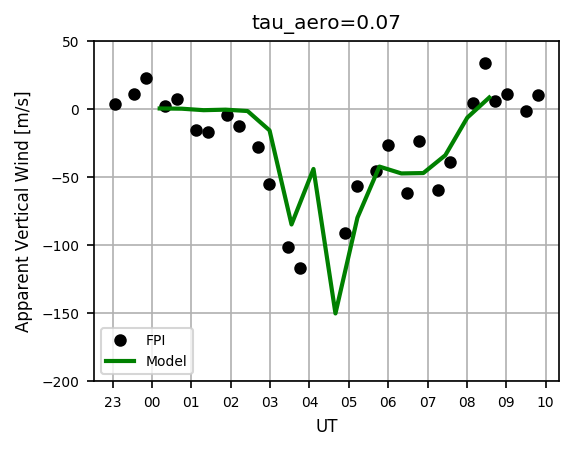

In [28]:
plot(fpi_t['Zenith'], fpi_wind['Zenith'],'ko', label='FPI', markersize=5)
plot(t_vec, w_app_mine, 'g-', label='Model', linewidth=2)


gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
grid()
xlabel('UT')
ylabel('Apparent Vertical Wind [m/s]')
legend(loc='best')
title('tau_aero=%.2f' % tau0_aerosol)

ylim((-200,50))

taustr = ''.join(('%4.3f' % tau0_aerosol).split('.'))
#savefig('/home/bhardin2/public_html/atmospheric_scatter/BU_FPI_with_stray_descatter_tau%s_%s.png' % (taustr,instr_name)) 
xlim()

#### Plot for CEDAR 2016 poster

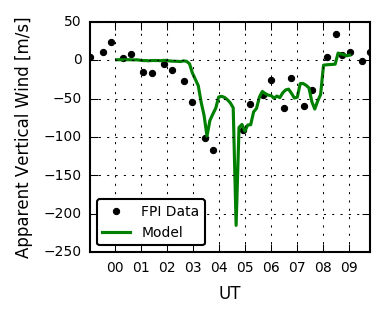

In [68]:
fig = figure(figsize=(6.75/2.8,5.55/2.8))

plot(fpi_t['Zenith'], fpi_wind['Zenith'],'ko', label='FPI Data', markersize=3)
plot(t_vec, w_app_mine, 'g-', label='Model', linewidth=1.5)


gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
grid()
xlabel('UT')
ylabel('Apparent Vertical Wind [m/s]')
legend(loc='best')

ylim((-250,50))

savefig('/home/bhardin2/public_html/atmospheric_scatter/cedar2016/data_model_MH.pdf',bbox_inches='tight')

#### Plot for CEDAR 2016 talk

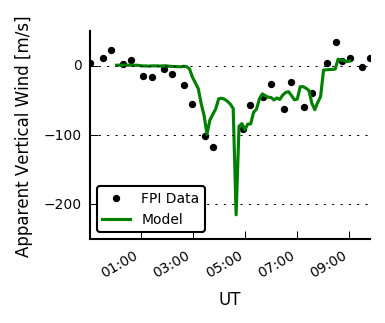

In [170]:
fig = figure(figsize=(6.75/2.8,5.55/2.8))

plot(fpi_t['Zenith'], fpi_wind['Zenith'],'ko', label='FPI Data', markersize=3)
plot(t_vec, w_app_mine, 'g-', label='Model', linewidth=1.5)


xlabel('UT')
ylabel('Apparent Vertical Wind [m/s]')
legend(loc='best')

# Hide the right and top spines
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
gca().yaxis.set_ticks_position('left')
gca().xaxis.set_ticks_position('bottom')
gcf().autofmt_xdate()
gca().xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
grid(axis='y')
xlabel('UT')
ylabel('Apparent Vertical Wind [m/s]')
yticks([0,-100,-200,-300])
xticks(xticks()[0][1::2])
ylim((-250,50))

savefig('/home/bhardin2/public_html/atmospheric_scatter/cedar2016/data_model_MH_talk.pdf',bbox_inches='tight')

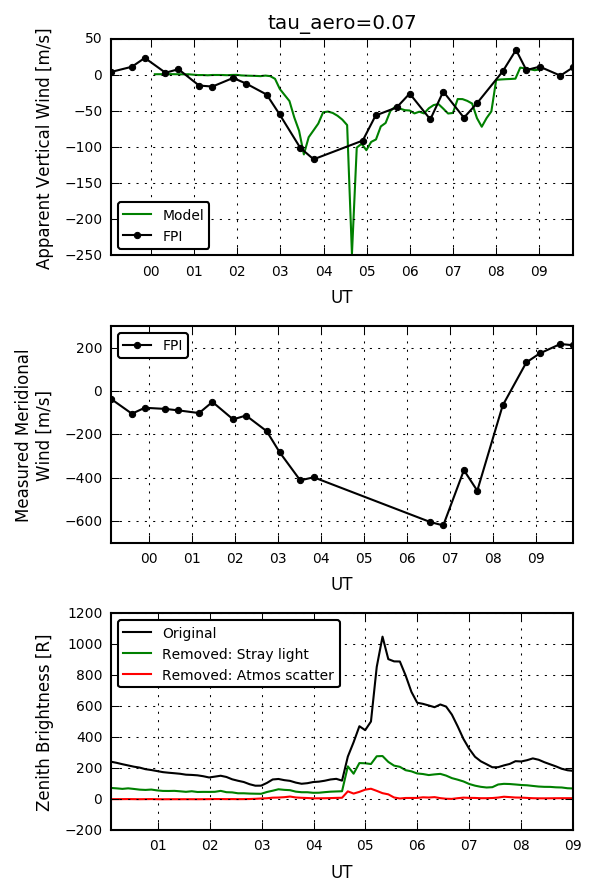

In [217]:
figure(figsize=(4,6))

subplot(3,1,1)

plot(t_vec, w_app_mine, 'g-', label='Model')
plot(fpi_t['Zenith'], fpi_wind['Zenith'],'k.-', label='FPI')

gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
grid()
xlabel('UT')
ylabel('Apparent Vertical Wind [m/s]')
legend(loc='best')
title('tau_aero=%.2f' % tau0_aerosol)

subplot(3,1,2)
plot(fpi_t['North'], fpi_wind['North'],'k.-', label='FPI')
gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
grid()
xlabel('UT')
ylabel('Measured Meridional\nWind [m/s]')
legend(loc='best')

subplot(3,1,3)
plot(t_vec, asi_orig_vec,'k-', label='Original')
plot(t_vec, asi_bg_vec,'g-', label='Removed: Stray light')
plot(t_vec, asi_scatt_vec,'r-', label='Removed: Atmos scatter')
gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
grid()
xlabel('UT')
ylabel('Zenith Brightness [R]')
legend(loc='best')

tight_layout()

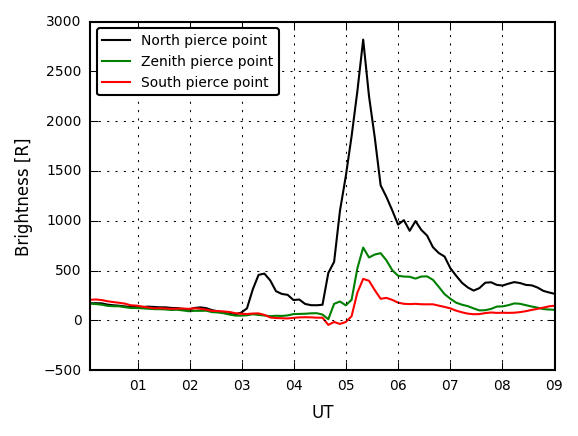

In [218]:
plot(t_vec, I_north_vec,'k-',label='North pierce point')
plot(t_vec, I_zenith_vec,'g-',label='Zenith pierce point')
plot(t_vec, I_south_vec,'r-',label='South pierce point')
gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
grid()
xlabel('UT')
ylabel('Brightness [R]')
legend(loc='best')

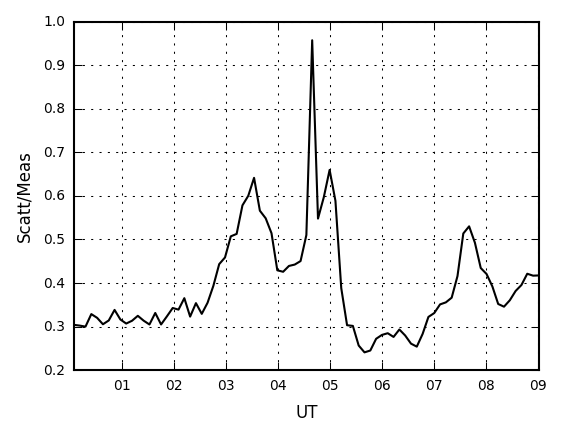

In [219]:
plot(t_vec, (array(asi_scatt_vec)+array(asi_bg_vec))/array(asi_orig_vec),'k-')
gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
grid()
xlabel('UT')
ylabel('Scatt/Meas')
legend(loc='best')

# Loop over time: Error in another direction

In [66]:
q_to_use = q

th_look  = array([45.0])
phi_look = array([180.0])
name_look = ['South']
Nlook = len(th_look)

# Where to sample to determine stray light
iv = [100, 50,  500, 500]
jv = [400,300, 110, 500]
# Updated 2016 Dec 7 so that the brightness in the South doesn't go negative
iv = [140, 50,  180, 250]
jv = [440,300, 100, 500]

instr_name = 'noto01'
year = 2013
doy = 274

bu_fns = glob.glob('/home/bhardin2/BU_ASI_data/*.sav')
bu_fns.sort()
#bu_fns = bu_fns[1:2]

t_vec = []
w_err = zeros(len(bu_fns))
T_err = zeros(len(bu_fns))
asi_orig_vec = []
asi_bg_vec = [] # brightness removed for stray light
asi_scatt_vec = [] # brightness removed for atmospheric scatter
I_south_vec = [] # actual vertical brightness at South pierce point (to check negativity)
I_north_vec = [] # actual vertical brightness at North pierce point
I_zenith_vec = [] # actual vertical brightness at Zenith pierce point 
model_intensity = {}
for direc in ['North','South','Zenith']:
    model_intensity[direc] = []
# Save estimated sky brightness map
Xs,Ys = meshgrid(linspace(-1000e3,1000e3,100),linspace(-1000e3,1000e3,100))
dhf_save = zeros((shape(Xs)[0], shape(Xs)[1], len(bu_fns)))

for ii in range(len(bu_fns)):
    
    clear_output(wait=True)
    time_mod.sleep(0.01)
    print '%i/%i '%(ii+1,len(bu_fns))
    sys.stdout.flush()
    
    ######################################### LOAD ASI DATA ####################################################
    bu_fn = bu_fns[ii]
    
    bu_file = readsav(bu_fn)
    im = bu_file['theimage'][100:700,100:700]


    # Load coordinates
    Xi,Yi = meshgrid(arange(100,700),arange(100,700))
    LAT = c_lat[0] + c_lat[1]*Xi + c_lat[2]*Yi + c_lat[3]*Xi*Yi + c_lat[4]*Xi**2 + c_lat[5]*Yi**2
    LON = c_lon[0] + c_lon[1]*Xi + c_lon[2]*Yi + c_lon[3]*Xi*Yi + c_lon[4]*Xi**2 + c_lon[5]*Yi**2
    # Convert to x,y
    DLAT = LAT - sitelat
    DLON = LON - sitelon
    X = DLON*111e3*cos(LAT*pi/180)
    Y = DLAT*111e3
    # Determine local slant angle for van-Rhijn correction
    # (van Rhijn is already corrected in BU data, but I need to un-correct)
    rho = sqrt(X**2 + Y**2)
    th = arcsin((RE+h)/sqrt(RE**2 + (RE+h)**2 - 2*RE*(RE+h)*cos(rho/(RE+h))) * sin(rho/(RE+h)))
    GAMMA = arcsin(RE/(RE+h) * sin(th)) # zenith angle (slant angle) at pierce point  
    

    # ASI stray light correction
    # Un-correct for van Rhijn
    im = im*sec(GAMMA)
    # Subtract background/stray-light/whatever-it-is
    bgs = []
    for kk in range(len(iv)):
        bgs.append(im[iv[kk],jv[kk]])
    bg = mean(bgs)
    #bg = 0
    im = im - bg
    # Re-correct for van Rhijn
    im = im/sec(GAMMA)
    
    # Load time
    t_asi_str = bu_fn.split('/')[-1][1:7]
    asi_t = datetime(2013,10,2, int(t_asi_str[0:2]), int(t_asi_str[2:4]), int(t_asi_str[4:6]))
    t_vec.append(asi_t)

    width = 10 # pixels

    # Find center of image
    idx = argmin(X**2 + Y**2)
    ic,jc = unravel_index(idx, shape(im))

    # Create a cut averaged over a strip around y=0
    imcut_raw = mean(im[:,jc-width:jc+width],axis=1)
    yim_raw = Y[:,jc]

    # Manually define a mask based on the trees.
    idx_valid = (yim_raw > -750e3) & (yim_raw < 1000e3)
    yim = yim_raw[idx_valid]
    imcut = imcut_raw[idx_valid]
    
    # Define 2D brightness distribution function
    dhf_interp = interpolate.interp1d(yim, imcut, bounds_error = False)

    def dhf(x,y):
        '''
        Airglow source VER function, integrated vertically. (i.e., thin-shell approximation).
        It is assumed that input variables are arrays of the same size.
        '''
        r_max = (RE+h) * arccos(RE/(RE+h))
        f = dhf_interp(y)
        f[y < yim[0]] = imcut[0] # Zero-order-hold extrapolation
        f[y > yim[-1]] = imcut[-1] # Zero-order-hold extrapolation
        f[x**2 + y**2 > r_max**2] = 0.0 # Nothing beyond horizon
        return f

    ################### DESCATTER ASI DATA ########################
    dhf_descatter = descatter_asi_data(imcut, yim, tau0, P, h, M=M, N=N, R=R, N_int=N_int, R_int=R_int, verbose = False)
    
    asi_scatt_vec.append(dhf(0,0)-dhf_descatter(0,0))
    asi_orig_vec.append(dhf(0,0) + bg)
    asi_bg_vec.append(bg)
    dhf_save[:,:,ii] = dhf_descatter(Xs, Ys)
    
    dhf = dhf_descatter
    
    I_south_vec.append(dhf(0,-h))
    I_north_vec.append(dhf(0,h))
    I_zenith_vec.append(dhf(0,0))
    
    #################################### LOAD FPI DATA #############################################
    
    fpir = FPIprocess.load_level0(instr_name, year, doy)['FPI_Results']

    # Re-establish Doppler ref (why doesn't this work well?)
    #dref, dreferr = FPI.DopplerReference(fpir, reference='laser', statistic='median')
    #fpir['LOSwind'] = fpir['LOSwind'] - dref
    
    direction = fpir['direction']    
    fpi_los_wind = {}
    fpi_los_wind_err = {}
    fpi_temp = {}
    fpi_intensity = {}
    fpi_t = {}
    for direc in list(set(direction)):
        fpi_los_wind[direc] = array([w for (w,d) in zip(fpir['LOSwind'], fpir['direction']) if d==direc])
        fpi_los_wind_err[direc] = array([w for (w,d) in zip(fpir['sigma_LOSwind'], fpir['direction']) if d==direc])
        fpi_temp[direc]     = array([w for (w,d) in zip(fpir['T'], fpir['direction']) if d==direc])
        fpi_intensity[direc]= array([w for (w,d) in zip(fpir['skyI'], fpir['direction']) if d==direc])
        fpi_t[direc]        = array([w.astimezone(pytz.utc).replace(tzinfo=None)\
                                     for (w,d) in zip(fpir['sky_times'], fpir['direction']) if d==direc])

    # Re-establish Doppler ref
    dref = mean(fpi_los_wind['Zenith'][0:9])
    for direc in fpi_los_wind.keys():
        fpi_los_wind[direc] -= dref

    # Transform to cardinal winds
    fpi_wind = {}
    for direc in fpi_los_wind.keys():
        if direc == 'Zenith':
            fpi_wind[direc] = fpi_los_wind[direc]
        else:
            fpi_wind[direc] = fpi_los_wind[direc]/cos(pi/4)
    fpi_wind['West'] = -fpi_wind['West']
    fpi_wind['South'] = -fpi_wind['South']  
    
    # Find the FPI sample nearest in time to estimate the horz wind and temperature
    i = {}
    for direc in fpi_t.keys():
         i[direc] = argmin(abs(array([(t-asi_t).total_seconds() for t in fpi_t[direc]])))

    T_fpi = fpi_temp['North'][i['North']]
    v_fpi = fpi_wind['North'][i['North']]

    # How to find zonal wind? Just pick one of these:
    u_east = fpi_wind['East'][i['East']]
    u_west = fpi_wind['West'][i['West']]
    u_los = (fpi_los_wind['East'][i['East']]-fpi_los_wind['West'][i['West']])/cos(pi/4)
    u_fpi = u_los
    
    uvw = array([u_fpi, v_fpi, 0.0])
    T = T_fpi
    
    
    ######################################## RT MODEL #########################################
    v, spectrum_scatt, spectrum_direct, spectrum_scatt_stray, spectrum_direct_stray = scattered_and_direct_spectra(dhf, 
                                                 tau0, P, h, th_look, phi_look, uvw, T,
                                                 q=q_to_use, full_fov_deg=full_fov_deg, M=M, N=N, R=R, N_int=N_int,
                                                 R_int=R_int, Q_int=Q_int, L=L, verbose=False)

    spectrum_meas = spectrum_direct + spectrum_scatt + spectrum_scatt_stray + spectrum_direct_stray

    w_app, T_app, I_app = analyze_spectrum(v,spectrum_meas[0,:])
    
    gamma_look = arcsin(RE/(RE+h) * sin(th_look[0]*pi/180)) # zenith angle (slant angle) at pierce point
    az_look = phi_look[0]*pi/180
    w_err[ii] = w_app - uvw.dot([sin(gamma_look)*sin(az_look), sin(gamma_look)*cos(az_look), 0.0])
    T_err[ii] = T_app - T
    
    ######### Save
    savez('/home/bhardin2/public_html/atmospheric_scatter/BU_FPI_saveset_horzerr_%04i_%03i.npz'%(year,doy),
              fpi_t_zenith = fpi_t['Zenith'],
              fpi_wind_zenith = fpi_wind['Zenith'],
              fpi_wind_error_zenith = fpi_los_wind_err['Zenith'],
              t_vec = t_vec,
              w_err = w_err,
              T_err = T_err,
              tau0_aerosol = tau0_aerosol,
              M = M,
              N = N,
              R = R,
              N_int = N_int,
              R_int = R_int,
              Q_int = Q_int,
              L = L,
              stray_i = iv,
              stray_j = jv,
              dhf_save = dhf_save,
              X_save = Xs,
              Y_save = Ys,
              year = year,
              doy = doy,
              asi_scatt_vec = asi_scatt_vec,
              asi_bg_vec = asi_bg_vec,
              asi_orig_vec = asi_orig_vec,
         )

81/81 


# Loop over time: horz wind and temperature

In [89]:
q_to_use = q
M = 5 # RT: resolution in altitude
N = 10  # RT: resolution in zenith angle (ideally, even but not a multiple of 4)
R = 6  # RT: resolution in azimuth angle
N_int = 15 # RT: source brightness resolution
R_int = 15 # RT: source brightness resolution
Q_int = 20 # resolution of FPI stray light calculation
L = 15 # number of wavelength bins

th_look  = array([0.0, 45.0, 45.0, 45.0, 45.0])
phi_look = array([0.0,  0.0,180.0, 90.0,270.0])
name_look = ['Zenith','North','South','East','West']
Nlook = len(th_look)

# Where to sample to determine stray light
iv = [100, 50,  500, 500]
jv = [400,300, 110, 500]

instr_name = 'noto01'
year = 2013
doy = 274

bu_fns = glob.glob('/home/bhardin2/BU_ASI_data/*.sav')
bu_fns.sort()
bu_fns = [bu_fns[31]]

t_vec = []
w_app_vec = zeros((len(th_look),len(bu_fns)))
T_app_vec = zeros((len(th_look),len(bu_fns)))
asi_orig_vec = []
asi_bg_vec = [] # brightness removed for stray light
asi_scatt_vec = [] # brightness removed for atmospheric scatter
I_south_vec = [] # actual vertical brightness at South pierce point (to check negativity)
I_north_vec = [] # actual vertical brightness at North pierce point
I_zenith_vec = [] # actual vertical brightness at Zenith pierce point
u_true_vec = []
v_true_vec = []
T_true_vec = []

for ii in range(len(bu_fns)):
    
    clear_output(wait=True)
    time_mod.sleep(0.01)
    print '%i/%i '%(ii+1,len(bu_fns))
    sys.stdout.flush()
    
    ######################################### LOAD ASI DATA ####################################################
    bu_fn = bu_fns[ii]
    
    bu_file = readsav(bu_fn)
    im = bu_file['theimage'][100:700,100:700]


    # Load coordinates
    Xi,Yi = meshgrid(arange(100,700),arange(100,700))
    LAT = c_lat[0] + c_lat[1]*Xi + c_lat[2]*Yi + c_lat[3]*Xi*Yi + c_lat[4]*Xi**2 + c_lat[5]*Yi**2
    LON = c_lon[0] + c_lon[1]*Xi + c_lon[2]*Yi + c_lon[3]*Xi*Yi + c_lon[4]*Xi**2 + c_lon[5]*Yi**2
    # Convert to x,y
    DLAT = LAT - sitelat
    DLON = LON - sitelon
    X = DLON*111e3*cos(LAT*pi/180)
    Y = DLAT*111e3
    # Determine local slant angle for van-Rhijn correction
    # (van Rhijn is already corrected in BU data, but I need to un-correct)
    rho = sqrt(X**2 + Y**2)
    th = arcsin((RE+h)/sqrt(RE**2 + (RE+h)**2 - 2*RE*(RE+h)*cos(rho/(RE+h))) * sin(rho/(RE+h)))
    GAMMA = arcsin(RE/(RE+h) * sin(th)) # zenith angle (slant angle) at pierce point  
    

    # ASI stray light correction
    # Un-correct for van Rhijn
    im = im*sec(GAMMA)
    # Subtract background/stray-light/whatever-it-is
    bgs = []
    for kk in range(len(iv)):
        bgs.append(im[iv[kk],jv[kk]])
    bg = mean(bgs)
    #bg = 0
    im = im - bg
    # Re-correct for van Rhijn
    im = im/sec(GAMMA)
    
    # Load time
    t_asi_str = bu_fn.split('/')[-1][1:7]
    asi_t = datetime(2013,10,2, int(t_asi_str[0:2]), int(t_asi_str[2:4]), int(t_asi_str[4:6]))
    t_vec.append(asi_t)

    width = 10 # pixels

    # Find center of image
    idx = argmin(X**2 + Y**2)
    ic,jc = unravel_index(idx, shape(im))

    # Create a cut averaged over a strip around y=0
    imcut_raw = mean(im[:,jc-width:jc+width],axis=1)
    yim_raw = Y[:,jc]

    # Manually define a mask based on the trees.
    idx_valid = (yim_raw > -750e3) & (yim_raw < 1000e3)
    yim = yim_raw[idx_valid]
    imcut = imcut_raw[idx_valid]
    
    # Define 2D brightness distribution function
    dhf_interp = interpolate.interp1d(yim, imcut, bounds_error = False)

    def dhf(x,y):
        '''
        Airglow source VER function, integrated vertically. (i.e., thin-shell approximation).
        It is assumed that input variables are arrays of the same size.
        '''
        r_max = (RE+h) * arccos(RE/(RE+h))
        f = dhf_interp(y)
        f[y < yim[0]] = imcut[0] # Zero-order-hold extrapolation
        f[y > yim[-1]] = imcut[-1] # Zero-order-hold extrapolation
        f[x**2 + y**2 > r_max**2] = 0.0 # Nothing beyond horizon
        return f

    ################### DESCATTER ASI DATA ########################
    dhf_descatter = descatter_asi_data(imcut, yim, tau0, P, h, M=M, N=N, R=R, N_int=N_int, R_int=R_int, verbose = False)
    
    asi_scatt_vec.append(dhf(0,0)-dhf_descatter(0,0))
    asi_orig_vec.append(dhf(0,0) + bg)
    asi_bg_vec.append(bg)
    
    dhf = dhf_descatter
    
    I_south_vec.append(dhf(0,-h))
    I_north_vec.append(dhf(0,h))
    I_zenith_vec.append(dhf(0,0))
    
    #################################### LOAD FPI DATA #############################################
    
    fpir = FPIprocess.load_level0(instr_name, year, doy)['FPI_Results']

    # Re-establish Doppler ref (why doesn't this work well?)
    #dref, dreferr = FPI.DopplerReference(fpir, reference='laser', statistic='median')
    #fpir['LOSwind'] = fpir['LOSwind'] - dref

    direction = fpir['direction']
    fpi_los_wind = {}
    fpi_temp = {}
    fpi_t = {}
    for direc in list(set(direction)):
        fpi_los_wind[direc] = array([w for (w,d) in zip(fpir['LOSwind'], fpir['direction']) if d==direc])
        fpi_temp[direc]     = array([w for (w,d) in zip(fpir['T'], fpir['direction']) if d==direc])
        fpi_t[direc]        = array([w.astimezone(pytz.utc).replace(tzinfo=None)\
                                     for (w,d) in zip(fpir['sky_times'], fpir['direction']) if d==direc])

    # Re-establish Doppler ref
    dref = mean(fpi_los_wind['Zenith'][0:9])
    for direc in fpi_los_wind.keys():
        fpi_los_wind[direc] -= dref

    # Transform to cardinal winds
    fpi_wind = {}
    for direc in fpi_los_wind.keys():
        if direc == 'Zenith':
            fpi_wind[direc] = fpi_los_wind[direc]
        else:
            fpi_wind[direc] = fpi_los_wind[direc]/cos(pi/4)
    fpi_wind['West'] = -fpi_wind['West']
    fpi_wind['South'] = -fpi_wind['South']  
    
    # Find the FPI sample nearest in time to estimate the horz wind and temperature
    i = {}
    for direc in fpi_t.keys():
         i[direc] = argmin(abs(array([(t-asi_t).total_seconds() for t in fpi_t[direc]])))

    T_fpi = fpi_temp['North'][i['North']]
    v_fpi = fpi_wind['North'][i['North']]

    # How to find zonal wind? Just pick one of these:
    u_east = fpi_wind['East'][i['East']]
    u_west = fpi_wind['West'][i['West']]
    u_los = (fpi_los_wind['East'][i['East']]-fpi_los_wind['West'][i['West']])/cos(pi/4)
    u_fpi = u_los
    
    uvw = array([u_fpi, v_fpi, 0.0])
    T = T_fpi
    
    
    ######################################## RT MODEL #########################################
    v, spectrum_scatt, spectrum_direct, spectrum_scatt_stray, spectrum_direct_stray = scattered_and_direct_spectra(dhf, 
                                                 tau0, P, h, th_look, phi_look, uvw, T,
                                                 q=q_to_use, full_fov_deg=full_fov_deg, M=M, N=N, R=R, N_int=N_int,
                                                 R_int=R_int, Q_int=Q_int, L=L, verbose=False)

    spectrum_meas = spectrum_direct + spectrum_scatt + spectrum_scatt_stray + spectrum_direct_stray
    
    for j in range(len(th_look)):
        w_app, T_app, I_app = analyze_spectrum(v,spectrum_meas[j,:])
        w_app_vec[j,ii] = w_app
        T_app_vec[j,ii] = T_app
    
    u_true_vec.append(u_fpi)
    v_true_vec.append(v_fpi)
    T_true_vec.append(T_fpi)



1/1 


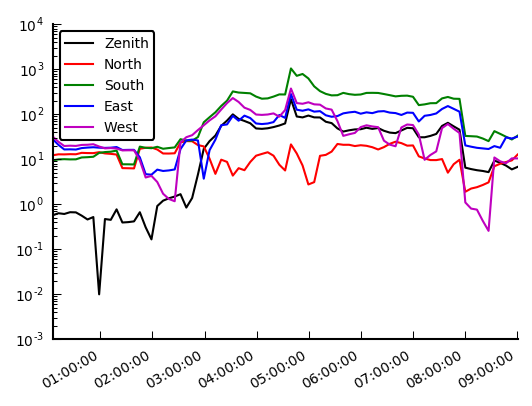

In [124]:
gamma_look = arcsin(RE/(RE+h) * sin(th_look[1]*pi/180)) # zenith angle (slant angle) at pierce point  

z_err = w_app_vec[0,:] - 0
n_err = w_app_vec[1,:]/sin(gamma_look) - v_true_vec
s_err =-w_app_vec[2,:]/sin(gamma_look) - v_true_vec
e_err = w_app_vec[3,:]/sin(gamma_look) - u_true_vec
w_err =-w_app_vec[4,:]/sin(gamma_look) - u_true_vec

#plot(t_vec, z_err, 'k-', label='Zenith')
#plot(t_vec, n_err, 'r-', label='North')
#plot(t_vec, s_err, 'g-', label='South')
#plot(t_vec, e_err, 'b-', label='East')
#plot(t_vec, w_err, 'm-', label='West')

semilogy(t_vec, abs(z_err), 'k-', label='Zenith')
semilogy(t_vec, abs(n_err), 'r-', label='North')
semilogy(t_vec, abs(s_err), 'g-', label='South')
semilogy(t_vec, abs(e_err), 'b-', label='East')
semilogy(t_vec, abs(w_err), 'm-', label='West')

legend(loc='best')
# Hide the right and top spines
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
gca().yaxis.set_ticks_position('left')
gca().xaxis.set_ticks_position('bottom')
gcf().autofmt_xdate()



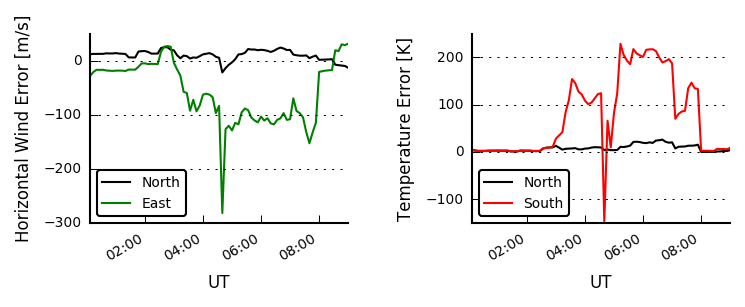

In [167]:
figure(figsize=(5,2))

subplot(1,2,1)
gamma_look = arcsin(RE/(RE+h) * sin(th_look[1]*pi/180)) # zenith angle (slant angle) at pierce point  
z_err = w_app_vec[0,:] - 0
n_err = w_app_vec[1,:]/sin(gamma_look) - v_true_vec
s_err =-w_app_vec[2,:]/sin(gamma_look) - v_true_vec
e_err = w_app_vec[3,:]/sin(gamma_look) - u_true_vec
w_err =-w_app_vec[4,:]/sin(gamma_look) - u_true_vec

#semilogy(t_vec, abs(w_err), 'm-', label='West')
plot(t_vec, n_err, 'k-', label='North')
plot(t_vec, e_err, 'g-', label='East')
#plot(t_vec, w_err, 'b-', label='East')

legend(loc='best')
# Hide the right and top spines
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
gca().yaxis.set_ticks_position('left')
gca().xaxis.set_ticks_position('bottom')
gcf().autofmt_xdate()
gca().xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
grid(axis='y')
xlabel('UT')
ylabel('Horizontal Wind Error [m/s]')
yticks([0,-100,-200,-300])
xticks(xticks()[0][1::2])

subplot(1,2,2)
z_err = T_app_vec[0,:] - T_true_vec
n_err = T_app_vec[1,:] - T_true_vec
s_err = T_app_vec[2,:] - T_true_vec
e_err = T_app_vec[3,:] - T_true_vec
w_err = T_app_vec[4,:] - T_true_vec

#semilogy(t_vec, abs(w_err), 'm-', label='West')
plot(t_vec, n_err, 'k-', label='North')
plot(t_vec, s_err, 'r-', label='South')

legend(loc='lower left')
# Hide the right and top spines
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
gca().yaxis.set_ticks_position('left')
gca().xaxis.set_ticks_position('bottom')
gcf().autofmt_xdate()
gca().xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
grid(axis='y')
xlabel('UT')
ylabel('Temperature Error [K]')
yticks([-100,0, 100, 200,])
xticks(xticks()[0][1::2])
tight_layout(w_pad=3.0)

savefig('/home/bhardin2/public_html/atmospheric_scatter/cedar2016/horz_and_temp_errs.pdf')

# Loop over time: Temperature Anisotropy

In [201]:
q_to_use = q
M = 10 # RT: resolution in altitude
N = 10  # RT: resolution in zenith angle (ideally, even but not a multiple of 4)
R = 6  # RT: resolution in azimuth angle
N_int = 20 # RT: source brightness resolution
R_int = 20 # RT: source brightness resolution
Q_int = 30 # resolution of FPI stray light calculation
L = 15 # number of wavelength bins

stray_pct = 0.02

th_look  = array([45.0, 45.0])
phi_look = array([180.0,0.0])
name_look = ['South','North']
y_locs = [0.0,-500.0]
Nlook = len(th_look)

# Where to sample to determine stray light
iv = [100, 50,  500, 500]
jv = [400,300, 110, 500]

instr_name = 'minime08'
year = 2013
doy = 274

bu_fns = glob.glob('/home/bhardin2/BU_ASI_data/*.sav')
bu_fns.sort()
#bu_fns = [bu_fns[10],bu_fns[31]]
#bu_fns = bu_fns[46:49]

t_vec = []
w_app_vec = zeros((len(th_look),len(bu_fns)))
T_app_vec = zeros((len(th_look),len(bu_fns)))
asi_orig_vec = []
asi_bg_vec = [] # brightness removed for stray light
asi_scatt_vec = [] # brightness removed for atmospheric scatter
I_south_vec = [] # actual vertical brightness at South pierce point (to check negativity)
I_north_vec = [] # actual vertical brightness at North pierce point
I_zenith_vec = [] # actual vertical brightness at Zenith pierce point
u_true_vec = []
v_true_vec = []
T_true_vec = []

for ii in range(len(bu_fns)):
    
    clear_output(wait=True)
    time_mod.sleep(0.01)
    print '%i/%i '%(ii+1,len(bu_fns))
    sys.stdout.flush()
    
    ######################################### LOAD ASI DATA ####################################################
    bu_fn = bu_fns[ii]
    
    bu_file = readsav(bu_fn)
    im = bu_file['theimage'][100:700,100:700]


    # Load coordinates
    Xi,Yi = meshgrid(arange(100,700),arange(100,700))
    LAT = c_lat[0] + c_lat[1]*Xi + c_lat[2]*Yi + c_lat[3]*Xi*Yi + c_lat[4]*Xi**2 + c_lat[5]*Yi**2
    LON = c_lon[0] + c_lon[1]*Xi + c_lon[2]*Yi + c_lon[3]*Xi*Yi + c_lon[4]*Xi**2 + c_lon[5]*Yi**2
    # Convert to x,y
    DLAT = LAT - sitelat
    DLON = LON - sitelon
    X = DLON*111e3*cos(LAT*pi/180)
    Y = DLAT*111e3
    # Determine local slant angle for van-Rhijn correction
    # (van Rhijn is already corrected in BU data, but I need to un-correct)
    rho = sqrt(X**2 + Y**2)
    th = arcsin((RE+h)/sqrt(RE**2 + (RE+h)**2 - 2*RE*(RE+h)*cos(rho/(RE+h))) * sin(rho/(RE+h)))
    GAMMA = arcsin(RE/(RE+h) * sin(th)) # zenith angle (slant angle) at pierce point  
    

    # ASI stray light correction
    # Un-correct for van Rhijn
    im = im*sec(GAMMA)
    # Subtract background/stray-light/whatever-it-is
    #bgs = []
    #for kk in range(len(iv)):
    #   bgs.append(im[iv[kk],jv[kk]])
    #bg = mean(bgs)
    bg = stray_pct*prctile(im,95)
    im = im - bg
    # Re-correct for van Rhijn
    im = im/sec(GAMMA)
    
    # Load time
    t_asi_str = bu_fn.split('/')[-1][1:7]
    asi_t = datetime(2013,10,2, int(t_asi_str[0:2]), int(t_asi_str[2:4]), int(t_asi_str[4:6]))
    t_vec.append(asi_t)

    width = 10 # pixels

    # Find center of image
    idx = argmin(X**2 + Y**2)
    ic,jc = unravel_index(idx, shape(im))

    # Create a cut averaged over a strip around y=0
    imcut_raw = mean(im[:,jc-width:jc+width],axis=1)
    yim_raw = Y[:,jc]

    # Manually define a mask based on the trees.
    idx_valid = (yim_raw > -750e3) & (yim_raw < 1000e3)
    yim = yim_raw[idx_valid]
    imcut = imcut_raw[idx_valid]
    
    # Define 2D brightness distribution function
    dhf_interp = interpolate.interp1d(yim, imcut, bounds_error = False)

    def dhf(x,y):
        '''
        Airglow source VER function, integrated vertically. (i.e., thin-shell approximation).
        It is assumed that input variables are arrays of the same size.
        '''
        r_max = (RE+h) * arccos(RE/(RE+h))
        f = dhf_interp(y)
        f[y < yim[0]] = imcut[0] # Zero-order-hold extrapolation
        f[y > yim[-1]] = imcut[-1] # Zero-order-hold extrapolation
        f[x**2 + y**2 > r_max**2] = 0.0 # Nothing beyond horizon
        return f

    ################### DESCATTER ASI DATA ########################
    dhf_descatter = descatter_asi_data(imcut, yim, tau0, P, h, M=M, N=N, R=R, N_int=N_int, R_int=R_int, verbose = False)
    
    asi_scatt_vec.append(dhf(0,0)-dhf_descatter(0,0))
    asi_orig_vec.append(dhf(0,0) + bg)
    asi_bg_vec.append(bg)
    
    dhf = dhf_descatter
    
    I_south_vec.append(dhf(0,-h))
    I_north_vec.append(dhf(0,h))
    I_zenith_vec.append(dhf(0,0))
    
    #################################### LOAD FPI DATA #############################################
    
    fpir = FPIprocess.load_level0(instr_name, year, doy)['FPI_Results']

    # Re-establish Doppler ref (why doesn't this work well?)
    #dref, dreferr = FPI.DopplerReference(fpir, reference='laser', statistic='median')
    #fpir['LOSwind'] = fpir['LOSwind'] - dref

    direction = fpir['direction']
    fpi_los_wind = {}
    fpi_temp = {}
    fpi_t = {}
    for direc in list(set(direction)):
        fpi_los_wind[direc] = array([w for (w,d) in zip(fpir['LOSwind'], fpir['direction']) if d==direc])
        fpi_temp[direc]     = array([w for (w,d) in zip(fpir['T'], fpir['direction']) if d==direc])
        fpi_t[direc]        = array([w.astimezone(pytz.utc).replace(tzinfo=None)\
                                     for (w,d) in zip(fpir['sky_times'], fpir['direction']) if d==direc])

    # Re-establish Doppler ref
    dref = mean(fpi_los_wind['Zenith'][0:9])
    for direc in fpi_los_wind.keys():
        fpi_los_wind[direc] -= dref

    # Transform to cardinal winds
    fpi_wind = {}
    for direc in fpi_los_wind.keys():
        if direc == 'Zenith':
            fpi_wind[direc] = fpi_los_wind[direc]
        else:
            fpi_wind[direc] = fpi_los_wind[direc]/cos(pi/4)
    fpi_wind['West'] = -fpi_wind['West']
    fpi_wind['South'] = -fpi_wind['South']  
    
    # Find the FPI sample nearest in time to estimate the horz wind and temperature
    i = {}
    for direc in fpi_t.keys():
         i[direc] = argmin(abs(array([(t-asi_t).total_seconds() for t in fpi_t[direc]])))

    T_fpi = fpi_temp['North'][i['North']]
    v_fpi = fpi_wind['North'][i['North']]

    # How to find zonal wind? Just pick one of these:
    u_east = fpi_wind['East'][i['East']]
    u_west = fpi_wind['West'][i['West']]
    u_los = (fpi_los_wind['East'][i['East']]-fpi_los_wind['West'][i['West']])/cos(pi/4)
    u_fpi = u_los
    
    uvw = array([u_fpi, v_fpi, 0.0])
    T = T_fpi
    
    
    ######################################## RT MODEL #########################################
    
    for j in range(len(th_look)):
        dhf_loc = lambda x,y: dhf(x,y-y_locs[j])
        
        v, spectrum_scatt, spectrum_direct, spectrum_scatt_stray, spectrum_direct_stray = scattered_and_direct_spectra(
                                                     dhf_loc, 
                                                     tau0, P, h, [th_look[j]], [phi_look[j]], uvw, T,
                                                     q=q_to_use, full_fov_deg=full_fov_deg, M=M, N=N, R=R, N_int=N_int,
                                                     R_int=R_int, Q_int=Q_int, L=L, verbose=False)

        spectrum_meas = spectrum_direct + spectrum_scatt + spectrum_scatt_stray + spectrum_direct_stray

        w_app, T_app, I_app = analyze_spectrum(v,spectrum_meas[0,:])
        w_app_vec[j,ii] = w_app
        T_app_vec[j,ii] = T_app
    
    u_true_vec.append(u_fpi)
    v_true_vec.append(v_fpi)
    T_true_vec.append(T_fpi)



81/81 


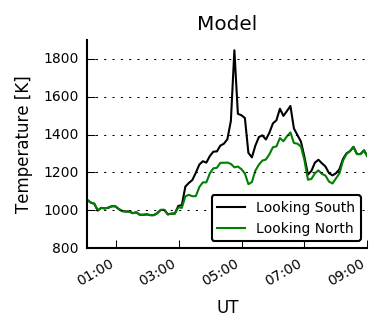

In [211]:
fig = figure(figsize=(6.75/2.8,5.55/2.8))

plot(t_vec,T_app_vec[0,:],'k-',label='Looking South')
plot(t_vec,T_app_vec[1,:],'g-',label='Looking North')
gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
grid()
xlabel('UT')
ylabel('Apparent Temperature [K]')
legend(loc='best')

# Hide the right and top spines
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
gca().yaxis.set_ticks_position('left')
gca().xaxis.set_ticks_position('bottom')
gcf().autofmt_xdate()
gca().xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
grid(axis='x')
xlabel('UT')
ylabel('Temperature [K]')
xticks(xticks()[0][0::2])
yticks(range(800,2000,200))
ylim((800,1900))
title('Model')

savefig('/home/bhardin2/public_html/atmospheric_scatter/cedar2016/T_anisotropy_model.pdf')

# Loop over time: brightness

In [50]:
q_to_use = q
M = 5
N = 6
R = 4
N_int = 10
R_int = 10

stray_pct = 0.08

th_look  = array([0.0, 45.0, 45.0])
ph_look = array([0.0, 0.0, 180.0])
name_look = ['Zenith','North','South']
Nlook = len(th_look)


instr_name = 'noto01'
year = 2013
doy = 274

bu_fns = glob.glob('/home/bhardin2/BU_ASI_data/*.sav')
bu_fns.sort()
#bu_fns = [bu_fns[31], bu_fns[32]]

t_vec = []
model_intensity = {}
for direc in ['North','South','Zenith']:
    model_intensity[direc] = []

for ii in range(len(bu_fns)):
    
    clear_output(wait=True)
    time_mod.sleep(0.01)
    print '%i/%i '%(ii+1,len(bu_fns))
    sys.stdout.flush()
    
    ######################################### LOAD ASI DATA ####################################################
    bu_fn = bu_fns[ii]
    
    bu_file = readsav(bu_fn)
    im = bu_file['theimage'][100:700,100:700]


    # Load coordinates
    Xi,Yi = meshgrid(arange(100,700),arange(100,700))
    LAT = c_lat[0] + c_lat[1]*Xi + c_lat[2]*Yi + c_lat[3]*Xi*Yi + c_lat[4]*Xi**2 + c_lat[5]*Yi**2
    LON = c_lon[0] + c_lon[1]*Xi + c_lon[2]*Yi + c_lon[3]*Xi*Yi + c_lon[4]*Xi**2 + c_lon[5]*Yi**2
    # Convert to x,y
    DLAT = LAT - sitelat
    DLON = LON - sitelon
    X = DLON*111e3*cos(LAT*pi/180)
    Y = DLAT*111e3
    # Determine local slant angle for van-Rhijn correction
    # (van Rhijn is already corrected in BU data, but I need to un-correct)
    rho = sqrt(X**2 + Y**2)
    th = arcsin((RE+h)/sqrt(RE**2 + (RE+h)**2 - 2*RE*(RE+h)*cos(rho/(RE+h))) * sin(rho/(RE+h)))
    GAMMA = arcsin(RE/(RE+h) * sin(th)) # zenith angle (slant angle) at pierce point  
    

    # ASI stray light correction
    # Un-correct for van Rhijn
    im = im*sec(GAMMA)
    # Subtract background/stray-light/whatever-it-is
    bg = stray_pct * prctile(im,95)
    #bg = 0
    im = im - bg
    # Re-correct for van Rhijn
    im = im/sec(GAMMA)
    
    # Load time
    t_asi_str = bu_fn.split('/')[-1][1:7]
    asi_t = datetime(2013,10,2, int(t_asi_str[0:2]), int(t_asi_str[2:4]), int(t_asi_str[4:6]))
    t_vec.append(asi_t)

    width = 10 # pixels

    # Find center of image
    idx = argmin(X**2 + Y**2)
    ic,jc = unravel_index(idx, shape(im))

    # Create a cut averaged over a strip around y=0
    imcut_raw = mean(im[:,jc-width:jc+width],axis=1)
    yim_raw = Y[:,jc]

    # Manually define a mask based on the trees.
    idx_valid = (yim_raw > -750e3) & (yim_raw < 1000e3)
    yim = yim_raw[idx_valid]
    imcut = imcut_raw[idx_valid]
    
    # Define 2D brightness distribution function
    dhf_interp = interpolate.interp1d(yim, imcut, bounds_error = False)

    def dhf(x,y):
        '''
        Airglow source VER function, integrated vertically. (i.e., thin-shell approximation).
        It is assumed that input variables are arrays of the same size.
        '''
        r_max = (RE+h) * arccos(RE/(RE+h))
        f = dhf_interp(y)
        f[y < yim[0]] = imcut[0] # Zero-order-hold extrapolation
        f[y > yim[-1]] = imcut[-1] # Zero-order-hold extrapolation
        f[x**2 + y**2 > r_max**2] = 0.0 # Nothing beyond horizon
        return f

    ################### DESCATTER ASI DATA ########################
    dhf_descatter = descatter_asi_data(imcut, yim, tau0, P, h, M=M, N=N, R=R, N_int=N_int, R_int=R_int, verbose = False)
    
    dhf = dhf_descatter
    
    
    #################################### LOAD FPI DATA #############################################
    
    fpir = FPIprocess.load_level0(instr_name, year, doy)['FPI_Results']

    # Re-establish Doppler ref (why doesn't this work well?)
    #dref, dreferr = FPI.DopplerReference(fpir, reference='laser', statistic='median')
    #fpir['LOSwind'] = fpir['LOSwind'] - dref

    direction = fpir['direction']
    fpi_los_wind = {}
    fpi_temp = {}
    fpi_t = {}
    for direc in list(set(direction)):
        fpi_los_wind[direc] = array([w for (w,d) in zip(fpir['LOSwind'], fpir['direction']) if d==direc])
        fpi_temp[direc]     = array([w for (w,d) in zip(fpir['T'], fpir['direction']) if d==direc])
        fpi_t[direc]        = array([w.astimezone(pytz.utc).replace(tzinfo=None)\
                                     for (w,d) in zip(fpir['sky_times'], fpir['direction']) if d==direc])

    # Re-establish Doppler ref
    dref = mean(fpi_los_wind['Zenith'][0:9])
    for direc in fpi_los_wind.keys():
        fpi_los_wind[direc] -= dref

    # Transform to cardinal winds
    fpi_wind = {}
    for direc in fpi_los_wind.keys():
        if direc == 'Zenith':
            fpi_wind[direc] = fpi_los_wind[direc]
        else:
            fpi_wind[direc] = fpi_los_wind[direc]/cos(pi/4)
    fpi_wind['West'] = -fpi_wind['West']
    fpi_wind['South'] = -fpi_wind['South']  
    
    # Find the FPI sample nearest in time to estimate the horz wind and temperature
    i = {}
    for direc in fpi_t.keys():
         i[direc] = argmin(abs(array([(t-asi_t).total_seconds() for t in fpi_t[direc]])))

    T_fpi = fpi_temp['North'][i['North']]
    v_fpi = fpi_wind['North'][i['North']]

    # How to find zonal wind? Just pick one of these:
    u_east = fpi_wind['East'][i['East']]
    u_west = fpi_wind['West'][i['West']]
    u_los = (fpi_los_wind['East'][i['East']]-fpi_los_wind['West'][i['West']])/cos(pi/4)
    u_fpi = u_los
    
    uvw = array([u_fpi, v_fpi, 0.0])
    T = T_fpi
    
    
    ######################################## RT MODEL #########################################
    gsc,gdir,ssc,sdir = scatter_along_los(dhf, tau0, P, h, th_look, ph_look,q=q_to_use, full_fov_deg=full_fov_deg,
                                          M=M, N=N, R=R, N_int=N_int,
                                          R_int=R_int, verbose=False)
    gtot = gsc + gdir + ssc + sdir
    for direc in ['North','South','Zenith']:
        # find index corresponding to this direction
        iD = find([direc==n for n in name_look])[0]
        model_intensity[direc].append(gtot[iD])
        

81/81 


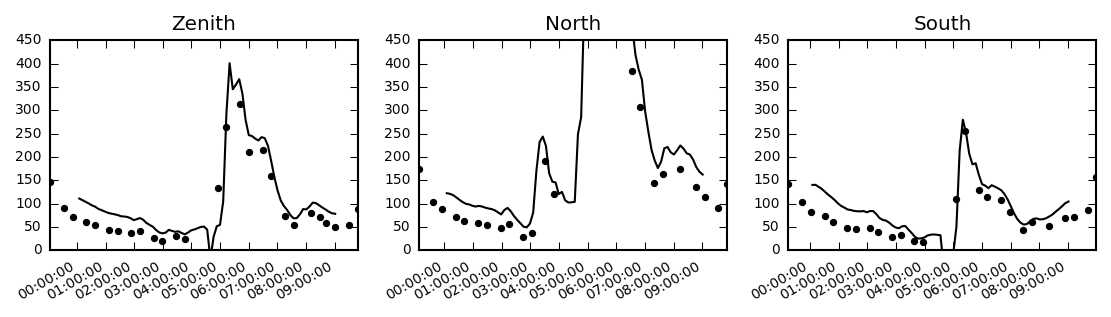

In [51]:
fpi_cal = 3.3 # guess just for plotting and eyeballing

figure(figsize=(9,2))
for i in range(3):
    subplot(1,3,i+1)
    direc = name_look[i]
    plot(t_vec, array(model_intensity[direc])/fpi_cal,'k-')
    plot(fpi_t[direc],fpi_intensity[direc],'k.')
    title(direc)
    ylim((0,450))
gcf().autofmt_xdate()

# ASI Stray light stuff

In [173]:
bu_fns = glob.glob('/home/bhardin2/BU_ASI_data/*.sav')
bu_fns.sort()

#bu_fns = [bu_fns[10],bu_fns[25]]#, bu_fns[35], bu_fns[50]]

M = 10
N = 10
R = 10
N_int = 20
R_int = 20
L = 20 # number of wavelength bins

iv = [100, 50,  500, 500]
jv = [400,300, 110, 500]

cols = ['g','r','y','c']

#M = 5
#N = 4
#R = 4
#N_int = 10
#R_int = 10
#L = 10


from scipy.io import readsav # read IDL save files
c_lat,c_lon,sitelat,sitelon = spatial_cal()
# Load coordinates
Xi,Yi = meshgrid(arange(100,700),arange(100,700))
LAT = c_lat[0] + c_lat[1]*Xi + c_lat[2]*Yi + c_lat[3]*Xi*Yi + c_lat[4]*Xi**2 + c_lat[5]*Yi**2
LON = c_lon[0] + c_lon[1]*Xi + c_lon[2]*Yi + c_lon[3]*Xi*Yi + c_lon[4]*Xi**2 + c_lon[5]*Yi**2
# Convert to x,y
DLAT = LAT - sitelat
DLON = LON - sitelon
X = DLON*111e3*cos(LAT*pi/180)
Y = DLAT*111e3


t_vec = []
bg_vec = []
bg2_vec = []
zen_vec = []

stray_light_frac = 0.07 # from Jeff Baumgardner, 2% of maximum


for fni in range(len(bu_fns)):
    
    clear_output(wait=True)
    time_mod.sleep(0.01)
    print '%i/%i' % (fni+1, len(bu_fns))
    sys.stdout.flush()
    
    ########### Load a particular (worst-case) file ###############


    bu_fn = bu_fns[fni]
    bu_file = readsav(bu_fn)
    im = bu_file['theimage'][100:700,100:700]
    
    # ASI stray light correction
    # Un-correct for van Rhijn
    im = im*sec(GAMMA)
    # Un-correct for calibration (whenever I get the Cal file)
    
    bg = []
    for k in range(len(iv)):
        bg.append(im[iv[k],jv[k]])
    bg_vec.append(bg)
    
    bg2_vec.append(stray_light_frac * prctile(im,95))
    
    zen_vec.append(im[300,300])
    
    # Load time
    t_asi_str = bu_fn.split('/')[-1][1:7]
    asi_t = datetime(2013,10,2, int(t_asi_str[0:2]), int(t_asi_str[2:4]), int(t_asi_str[4:6]))
    t_vec.append(asi_t)
    
bg_vec = array(bg_vec)
bg2_vec = array(bg2_vec)
zen_vec = array(zen_vec)

81/81


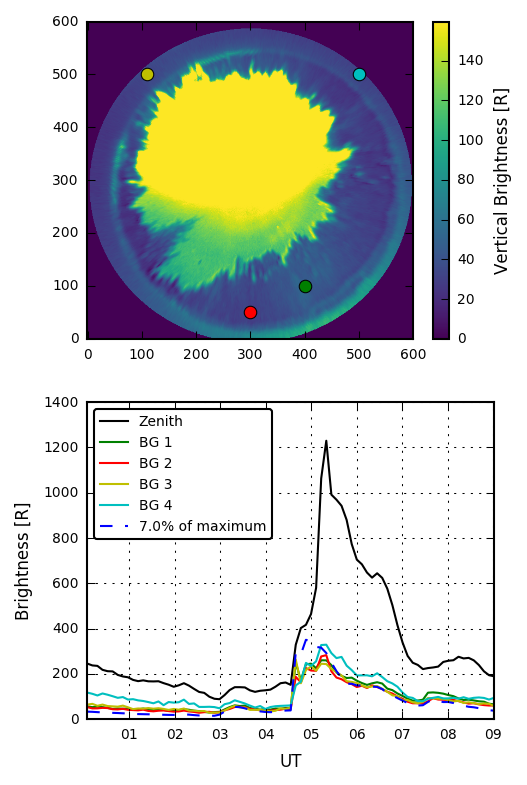

In [174]:
figure(figsize=(3.5,6))

subplot(2,1,1)
bu_fn = '/home/bhardin2/BU_ASI_data/M073345.sav'
bu_file = readsav(bu_fn)
im = bu_file['theimage'][100:700,100:700]

imshow(im, cmap='viridis',vmin=0, vmax=prctile(im,80))
gca().invert_yaxis()
cb = colorbar()
cb.set_label('Vertical Brightness [R]')
for k in range(len(iv)):
    plot(jv[k],iv[k],'%so'%cols[k])
axis('tight')

subplot(2,1,2)
plot(t_vec, zen_vec,'k-',label='Zenith')
for k in range(len(iv)):
    plot(t_vec, bg_vec[:,k],'%s-'%cols[k],label='BG %i' % (k+1))
plot(t_vec, bg2_vec, 'b--',label='%.1f%% of maximum' % (stray_light_frac*100))
legend(loc='best')
gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
xlabel('UT')
ylabel('Brightness [R]')
grid()

#savefig('/home/bhardin2/public_html/atmospheric_scatter/ASI_stray_light.png')

# With de-atmos-scattering

In [60]:
bu_fns = glob.glob('/home/bhardin2/BU_ASI_data/*.sav')
bu_fns.sort()

#bu_fns = [bu_fns[10],bu_fns[42], bu_fns[45], bu_fns[50]]
bu_fns = bu_fns[39:45]

#M = 10
#N = 10
#R = 10
#N_int = 20
#R_int = 20

M = 5
N = 6
R = 4
N_int = 10
R_int = 10

#iv = [100, 50,  500, 500]
#jv = [400,300, 110, 500]

# Updated 2016 Dec 7 so that the brightness in the South doesn't go negative
iv = [140, 50,  180, 250]
jv = [440,300, 100, 500]
cols = ['g','r','y','c']

# Copied from above
#iv = [100, 50,  500, 500]
#jv = [400,300, 110, 500]


from scipy.io import readsav # read IDL save files
c_lat,c_lon,sitelat,sitelon = spatial_cal()
# Load coordinates
Xi,Yi = meshgrid(arange(100,700),arange(100,700))
LAT = c_lat[0] + c_lat[1]*Xi + c_lat[2]*Yi + c_lat[3]*Xi*Yi + c_lat[4]*Xi**2 + c_lat[5]*Yi**2
LON = c_lon[0] + c_lon[1]*Xi + c_lon[2]*Yi + c_lon[3]*Xi*Yi + c_lon[4]*Xi**2 + c_lon[5]*Yi**2
# Convert to x,y
DLAT = LAT - sitelat
DLON = LON - sitelon
X = DLON*111e3*cos(LAT*pi/180)
Y = DLAT*111e3

t_vec = []
bg_vec = []
zen_vec = []
south_vec = []
bg_vec = []


for fni in range(len(bu_fns)):
    
    clear_output(wait=True)
    time_mod.sleep(0.01)
    print '%i/%i' % (fni+1, len(bu_fns))
    sys.stdout.flush()
    
    bu_fn = bu_fns[fni]
    bu_file = readsav(bu_fn)
    im = bu_file['theimage'][100:700,100:700]

    # ASI stray light correction
    # Un-correct for van Rhijn
    im = im*sec(GAMMA)
    # Subtract background/stray-light/whatever-it-is
    bgs = []
    for ii in range(len(iv)):
        bgs.append(im[iv[ii],jv[ii]])
    bg = mean(bgs)
    #bg = 0
    im = im - bg
    # Re-correct for van Rhijn
    im = im/sec(GAMMA)
    
    # Load time
    t_asi_str = bu_fn.split('/')[-1][1:7]
    asi_t = datetime(2013,10,2, int(t_asi_str[0:2]), int(t_asi_str[2:4]), int(t_asi_str[4:6]))

    width = 10 # pixels

    # Find center of image
    idx = argmin(X**2 + Y**2)
    ic,jc = unravel_index(idx, shape(im))

    # Create a cut averaged over a strip around y=0
    imcut_raw = mean(im[:,jc-width:jc+width],axis=1)
    yim_raw = Y[:,jc]

    # Manually define a mask based on the trees.
    idx_valid = (yim_raw > -750e3) & (yim_raw < 1000e3)
    yim = yim_raw[idx_valid]
    imcut = imcut_raw[idx_valid]
    

    ################### DESCATTER ASI DATA ########################
    dhf_descatter = descatter_asi_data(imcut, yim, tau0, P, h, M=M, N=N, R=R, N_int=N_int, R_int=R_int, verbose = False)
    
    t_vec.append(asi_t)
    zen_vec.append(dhf_descatter(0,0))
    south_vec.append(dhf_descatter(0,-400e3))
    bg_vec.append(bg)

6/6


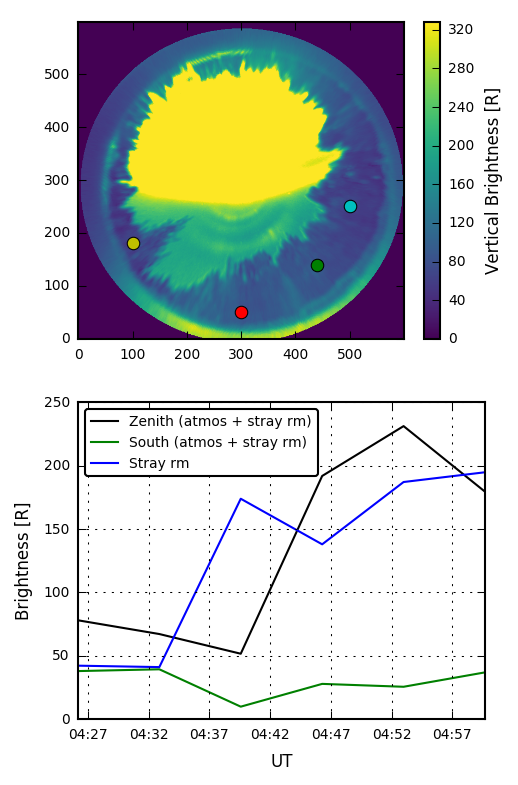

In [61]:
figure(figsize=(3.5,6))

subplot(2,1,1)
bu_fn = '/home/bhardin2/BU_ASI_data/M045259.sav'
bu_file = readsav(bu_fn)
im = bu_file['theimage'][100:700,100:700]

imshow(im, cmap='viridis',vmin=0, vmax=prctile(im,92))
gca().invert_yaxis()
cb = colorbar()
cb.set_label('Vertical Brightness [R]')
for k in range(len(iv)):
    plot(jv[k],iv[k],'%so'%cols[k])
axis('tight')

subplot(2,1,2)
plot(t_vec, zen_vec,'k-',label='Zenith (atmos + stray rm)')
plot(t_vec, south_vec,'g-',label='South (atmos + stray rm)')
plot(t_vec, bg_vec, 'b-',label='Stray rm')
legend(loc='best')
gca().xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
xlabel('UT')
ylabel('Brightness [R]')
grid()

clim(0, prctile(im,80))

#savefig('/home/bhardin2/public_html/atmospheric_scatter/ASI_stray_light.png')

# OLD CODE SAVED FOR POSTERITY

Everything below here has not (yet) been updated to use the standard atmospheric_scatter.py module. Please do so, future Brian, if you'd like to do these analyses again.

# Loop over time: Apparent temperature anisotropy

In [77]:

M = 10
N = 8
R = 8
N_int = 20
R_int = 20
Q_int = 30
L = 20
K = 20

y_instr_vec = [0.0, -500e3] # location of instrument North-South
th_look_vec = [45.0, 45.0]
phi_look_vec = [180.0, 0.0]
Ns = len(y_instr_vec)

instr_name = 'minime06'
year = 2013
doy = 274

bu_fns = glob.glob('/home/bhardin2/BU_ASI_data/*.sav')
bu_fns.sort()
bu_fns = bu_fns[46:49]


t_vec = []
w_app_vec = zeros((Ns,len(bu_fns)))
T_app_vec = zeros((Ns,len(bu_fns)))
I_app_vec = zeros((Ns,len(bu_fns)))

for ii in range(len(bu_fns)):
    
    clear_output(wait=True)
    time_mod.sleep(0.01)
    print '%i/%i '%(ii+1,len(bu_fns))
    sys.stdout.flush()
    
    ######################################### LOAD ASI DATA ####################################################
    bu_fn = bu_fns[ii]
    
    bu_file = readsav(bu_fn)
    im = bu_file['theimage'][100:700,100:700]

    # Load time
    t_asi_str = bu_fn.split('/')[-1][1:7]
    asi_t = datetime(2013,10,2, int(t_asi_str[0:2]), int(t_asi_str[2:4]), int(t_asi_str[4:6]))
    t_vec.append(asi_t)

    # Load coordinates
    Xi,Yi = meshgrid(arange(100,700),arange(100,700))
    LAT = c_lat[0] + c_lat[1]*Xi + c_lat[2]*Yi + c_lat[3]*Xi*Yi + c_lat[4]*Xi**2 + c_lat[5]*Yi**2
    LON = c_lon[0] + c_lon[1]*Xi + c_lon[2]*Yi + c_lon[3]*Xi*Yi + c_lon[4]*Xi**2 + c_lon[5]*Yi**2

    # Convert to x,y
    DLAT = LAT - sitelat
    DLON = LON - sitelon
    X = DLON*111e3*cos(LAT*pi/180)
    Y = DLAT*111e3

    width = 10 # pixels

    # Find center of image
    idx = argmin(X**2 + Y**2)
    ic,jc = unravel_index(idx, shape(im))

    # Create a cut averaged over a strip around y=0
    imcut_raw = mean(im[:,jc-10:jc+10],axis=1)
    yim_raw = Y[:,jc]

    # Manually define a mask based on the trees.
    idx_valid = (yim_raw > -750e3) & (yim_raw < 1000e3)
    yim = yim_raw[idx_valid]
    imcut = imcut_raw[idx_valid]

    # Define 2D brightness distribution function
    dhf_interp = interpolate.interp1d(yim, imcut, bounds_error = False)

    def dhf(x,y):
        '''
        Airglow source VER function, integrated vertically. (i.e., thin-shell approximation).
        It is assumed that input variables are arrays of the same size.
        '''
        r_max = (RE+h) * arccos(RE/(RE+h))
        f = dhf_interp(y)
        f[y < yim[0]] = imcut[0] # Zero-order-hold extrapolation
        f[y > yim[-1]] = imcut[-1] # Zero-order-hold extrapolation
        f[x**2 + y**2 > r_max**2] = 0.0 # Nothing beyond horizon
        return f
    
    
    #################################### LOAD FPI DATA #############################################
    
    fpir = FPIprocess.load_level0(instr_name, year, doy)['FPI_Results']

    # Re-establish Doppler ref (why doesn't this work well?)
    #dref, dreferr = FPI.DopplerReference(fpir, reference='laser', statistic='median')
    #fpir['LOSwind'] = fpir['LOSwind'] - dref

    direction = fpir['direction']
    fpi_los_wind = {}
    fpi_temp = {}
    fpi_t = {}
    for direc in list(set(direction)):
        fpi_los_wind[direc] = array([w for (w,d) in zip(fpir['LOSwind'], fpir['direction']) if d==direc])
        fpi_temp[direc]     = array([w for (w,d) in zip(fpir['T'], fpir['direction']) if d==direc])
        fpi_t[direc]        = array([w.astimezone(pytz.utc).replace(tzinfo=None)\
                                     for (w,d) in zip(fpir['sky_times'], fpir['direction']) if d==direc])

    # Re-establish Doppler ref
    dref = mean(fpi_los_wind['Zenith'][0:9])
    for direc in fpi_los_wind.keys():
        fpi_los_wind[direc] -= dref

    # Transform to cardinal winds
    fpi_wind = {}
    for direc in fpi_los_wind.keys():
        if direc == 'Zenith':
            fpi_wind[direc] = fpi_los_wind[direc]
        else:
            fpi_wind[direc] = fpi_los_wind[direc]/cos(pi/4)
    fpi_wind['West'] = -fpi_wind['West']
    fpi_wind['South'] = -fpi_wind['South']  
    
    # Find the FPI sample nearest in time to estimate the horz wind and temperature
    i = {}
    for direc in fpi_t.keys():
         i[direc] = argmin(abs(array([(t-asi_t).total_seconds() for t in fpi_t[direc]])))

    T_fpi = fpi_temp['North'][i['North']]
    v_fpi = fpi_wind['North'][i['North']]

    # How to find zonal wind? Just pick one of these:
    u_east = fpi_wind['East'][i['East']]
    u_west = fpi_wind['West'][i['West']]
    u_los = (fpi_los_wind['East'][i['East']]-fpi_los_wind['West'][i['West']])/cos(pi/4)
    u_fpi = u_los
    
    ######################################## RT MODEL #########################################

    for jj in range(Ns):
        th_look = th_look_vec[jj]
        phi_look = phi_look_vec[jj]
        spectrum_direct = zeros(L)
        spectrum_scatt = zeros(L)
        
        T = T_fpi
        uwind = u_fpi
        vwind = v_fpi
        wwind = 0.0
        u = array([uwind, vwind, wwind])

        v = linspace(-3000,3000,L)

        # Define emissivity distribution function for this instrument
        dhf_jj = lambda x,y: dhf(x,y-y_instr_vec[jj])

        for l in range(L):

            # Define function that will give brightness in this wavelength band
            dhf_l = lambda x,y: spectral_intensity(dhf_jj,x,y,v[l],u,T)

            # Calculate direct and scattered spectra
            # Use this function to evaluate white-light scatter at this wavelength
            g_sc, g_dir = scatter_along_los(dhf_l, tau0, q, P, [th_look], [phi_look], M=M, N=N, R=R, \
                                              N_int=N_int, R_int=R_int, Q_int=Q_int, K=K, verbose=False)
            spectrum_scatt[l] = g_sc
            spectrum_direct[l] = g_dir

        spectrum = spectrum_scatt + spectrum_direct
        w_app, T_app = analyze_spectrum(v,spectrum)
        w_app_vec[jj,ii] = w_app
        T_app_vec[jj,ii] = T_app
        I_app_vec[jj,ii] = sum(spectrum)*(v[1]-v[0]) / dS # Apparent (slant) intensity
    

1/2 


KeyboardInterrupt: 

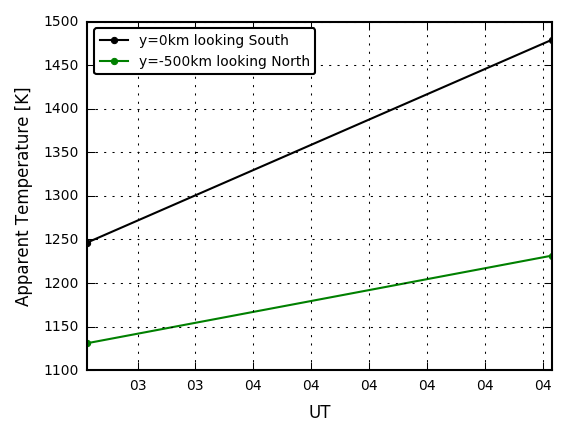

In [69]:
plot(t_vec,T_app_vec[0,:],'k.-',label='y=0km looking South')
plot(t_vec,T_app_vec[1,:],'g.-',label='y=-500km looking North')
gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
grid()
xlabel('UT')
ylabel('Apparent Temperature [K]')
legend(loc='best')

#savefig('/home/bhardin2/public_html/atmospheric_scatter/temperature_anisotropy.png')

# Loop over time: intensity

In [94]:
tau0_aerosol = 0.1
# Calculate total optical thickness and total effective phase function
tau0 = tau0_aerosol + tau0_rayleigh
P = lambda u0,u1,phi0,phi1: tau0_aerosol/tau0*P_aerosol(u0,u1,phi0,phi1) + tau0_rayleigh/tau0*P_rayleigh(u0,u1,phi0,phi1)

######### TEMP:
tau0 = 0.0
P = P_aerosol

direc_vec =    ['North','South','Zenith']
th_look_vec =  [45.0,   45.0,   0.0]
phi_look_vec = [0.0,    180.0,  0.0]
Ndirec = len(direc_vec)
M = 10
N = 6
R = 6
K = 20
N_int = 20
R_int = 20
Q_int = 20
h = 400e3

# Define a zero stray light function for testing
q0 = lambda x: 0.0

bu_fns = glob.glob('/home/bhardin2/BU_ASI_data/*.sav')
#bu_fns = bu_fns[::5]
#bu_fns = ['/home/bhardin2/BU_ASI_data/M063328.sav', '/home/bhardin2/BU_ASI_data/M011838.sav']
bu_fns.sort()

model_t = {}
model_I = {}

for di in range(Ndirec):
    direc = direc_vec[di]
    th_look = th_look_vec[di]
    phi_look = phi_look_vec[di]
    model_t[direc] = []
    model_I[direc] = zeros(len(bu_fns))

    for ii in range(len(bu_fns)):

        clear_output(wait=True)
        time_mod.sleep(0.01)
        print '%s: %i/%i '%(direc, ii+1,len(bu_fns))
        sys.stdout.flush()

        ######################################### LOAD ASI DATA ####################################################
        bu_fn = bu_fns[ii]

        bu_file = readsav(bu_fn)
        im = bu_file['theimage'][100:700,100:700]

        # Load time
        t_asi_str = bu_fn.split('/')[-1][1:7]
        asi_t = datetime(2013,10,2, int(t_asi_str[0:2]), int(t_asi_str[2:4]), int(t_asi_str[4:6]))

        # Load coordinates
        Xi,Yi = meshgrid(arange(100,700),arange(100,700))
        LAT = c_lat[0] + c_lat[1]*Xi + c_lat[2]*Yi + c_lat[3]*Xi*Yi + c_lat[4]*Xi**2 + c_lat[5]*Yi**2
        LON = c_lon[0] + c_lon[1]*Xi + c_lon[2]*Yi + c_lon[3]*Xi*Yi + c_lon[4]*Xi**2 + c_lon[5]*Yi**2

        # Convert to x,y
        DLAT = LAT - sitelat
        DLON = LON - sitelon
        X = DLON*111e3*cos(LAT*pi/180)
        Y = DLAT*111e3

        width = 10 # pixels

        # Find center of image
        idx = argmin(X**2 + Y**2)
        ic,jc = unravel_index(idx, shape(im))

        # Create a cut averaged over a strip around y=0
        imcut_raw = mean(im[:,jc-10:jc+10],axis=1)
        yim_raw = Y[:,jc]

        # Manually define a mask based on the trees.
        idx_valid = (yim_raw > -750e3) & (yim_raw < 1000e3)
        yim = yim_raw[idx_valid]
        imcut = imcut_raw[idx_valid]

        # Define 2D brightness distribution function
        dhf_interp = interpolate.interp1d(yim, imcut, bounds_error = False)

        def dhf(x,y):
            '''
            Airglow source VER function, integrated vertically. (i.e., thin-shell approximation).
            It is assumed that input variables are arrays of the same size.
            '''
            r_max = (RE+h) * arccos(RE/(RE+h))
            f = dhf_interp(y)
            f[y < yim[0]] = imcut[0] # Zero-order-hold extrapolation
            f[y > yim[-1]] = imcut[-1] # Zero-order-hold extrapolation
            f[x**2 + y**2 > r_max**2] = 0.0 # Nothing beyond horizon
            return f

        ######################################## RT MODEL #########################################

        g_sc, g_dir = white_light_scatter(dhf, tau0, q0, P, th_look, phi_look, M=M, N=N, R=R, N_int=N_int,\
                                              R_int=R_int, Q_int=Q_int, K=K, verbose=False)

        model_t[direc].append(asi_t)
        model_I[direc][ii] = g_sc + g_dir

        ######### Plot
        #plot(t_vec, w_app_mine[:ii+1], 'g-', label='Model')
        #plot(fpi_t['Zenith'], fpi_wind['Zenith'],'k.-', label='FPI')
        #gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
        #grid()
        #xlabel('UT')
        #ylabel('Apparent Vertical Wind [m/s]')
        #legend(loc='best')
        #title('tau=%.2f' % tau0)
        #savefig('/home/bhardin2/public_html/atmospheric_scatter/BU_FPI_with_stray_tau010.png')
        #close()

Zenith: 81/81 


In [95]:
import FPIprocess
from matplotlib import dates
import pytz
import FPI
import glob

instr_name = 'minime08'
year = 2013
doy = 274

fpir = FPIprocess.load_level0(instr_name, year, doy)['FPI_Results']

# Re-establish Doppler ref (why doesn't this work well?)
#dref, dreferr = FPI.DopplerReference(fpir, reference='laser', statistic='median')
#fpir['LOSwind'] = fpir['LOSwind'] - dref

direction = fpir['direction']
fpi_los_wind = {}
fpi_temp = {}
fpi_intensity = {}
fpi_t = {}
for direc in list(set(direction)):
    fpi_los_wind[direc] = array([w for (w,d) in zip(fpir['LOSwind'], fpir['direction']) if d==direc])
    fpi_temp[direc]     = array([w for (w,d) in zip(fpir['T'], fpir['direction']) if d==direc])
    fpi_intensity[direc]= array([w for (w,d) in zip(fpir['skyI'], fpir['direction']) if d==direc])
    fpi_t[direc]        = array([w.astimezone(pytz.utc).replace(tzinfo=None)\
                                 for (w,d) in zip(fpir['sky_times'], fpir['direction']) if d==direc])

# Re-establish Doppler ref
dref = mean(fpi_los_wind['Zenith'][0:9])
for direc in fpi_los_wind.keys():
    fpi_los_wind[direc] -= dref

# Transform to cardinal winds
fpi_wind = {}
for direc in fpi_los_wind.keys():
    if direc == 'Zenith':
        fpi_wind[direc] = fpi_los_wind[direc]
    else:
        fpi_wind[direc] = fpi_los_wind[direc]/cos(pi/4)
fpi_wind['West'] = -fpi_wind['West']
fpi_wind['South'] = -fpi_wind['South']

In [96]:
# Determine calibration factor from first few hours of data
mo_I_all = []
fpi_I_all = []
thr_start = 0.0
thr_stop = 1.0

for di in range(Ndirec):
    mo_hr = array([(t-datetime(t.year, t.month, t.day)).total_seconds()/3600. for t in model_t[direc]])
    fpi_hr = array([(t-datetime(t.year, t.month, t.day)).total_seconds()/3600. for t in fpi_t[direc]])
    mo_i = (mo_hr >= thr_start) & (mo_hr <= thr_stop)
    fpi_i = (fpi_hr >= thr_start) & (fpi_hr <= thr_stop)
    fpi_I_all.extend(fpi_intensity[direc][fpi_i])
    mo_I_all.extend(model_I[direc][mo_i])

sc = mean(mo_I_all)/mean(fpi_I_all)    

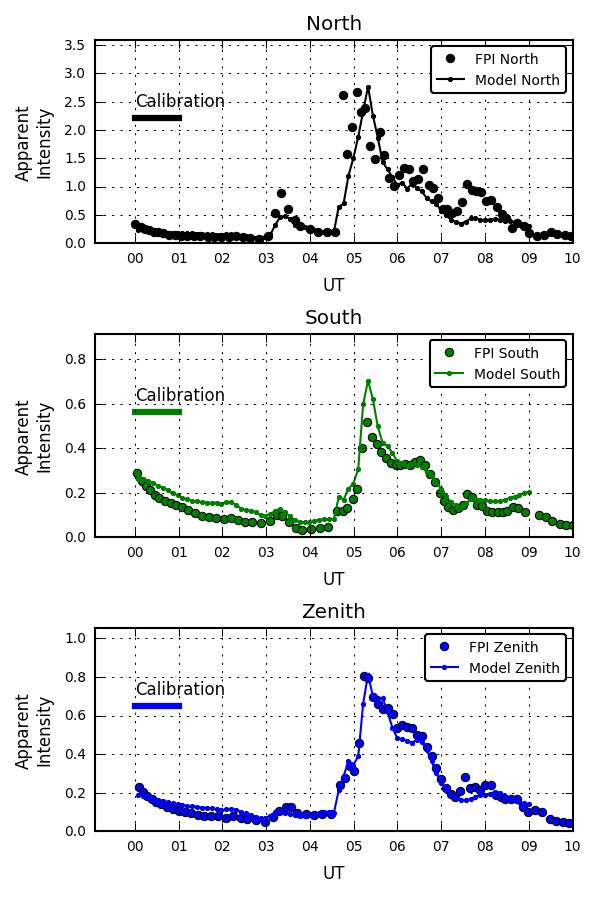

In [97]:
cols = ['k','g','b','r','m']

figure(figsize=(4,Ndirec*2))

tr = model_t[direc_vec[0]][-1]
tstart = datetime(tr.year, tr.month, tr.day) + timedelta(hours=thr_start)
tstop = datetime(tr.year, tr.month, tr.day) + timedelta(hours=thr_stop)

for di in range(Ndirec):
    subplot(Ndirec,1,di+1)
    direc = direc_vec[di]
    mo_t = model_t[direc]
    mo_I = model_I[direc]
    plot(fpi_t[direc], sc*fpi_intensity[direc],'%so'%cols[di],label='FPI %s' % direc, markersize=4)
    plot(mo_t, mo_I, '%s.-'%cols[di], label='Model %s' % direc, markersize=4)
    plot([tstart, tstop], [0.8*mo_I.max(), 0.8*mo_I.max()], '%s-'%cols[di], linewidth=3)
    text(tstart,0.85*mo_I.max(),'Calibration', horizontalalignment='left',verticalalignment='bottom')   
    gca().xaxis.set_major_formatter(dates.DateFormatter('%H'))
    grid()
    xlabel('UT')
    ylabel('Apparent\nIntensity')
    legend(loc='best')
    title(direc)
    ylim((0,1.3*mo_I.max()))
    xlim((min(mo_t)-timedelta(hours=1), max(mo_t)+timedelta(hours=1)))
tight_layout()

savefig('/home/bhardin2/public_html/atmospheric_scatter/BU_FPI_intensity_%s'%(instr_name))